# World Data League 2022

## 🎯 Challenge
Predicting the flow of people for public transportation improvements.

## Team: Padrão dos Descobrimentos
## 👥 Authors
* Alexandra Serras

## 💻 Development

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from meteostat import Daily, Monthly
from datetime import datetime
from tqdm import tqdm 
from datetime import date, datetime, timedelta
import holidays
import seaborn as sns 
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import (
    plot_pacf,
)
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import gtfsutils
import gtfsutils.routes
import gtfsutils.filter
import gtfs_functions as gtfs

**Disclaimer**

In general, the dataset we have with the mobility in 2020 isn't the ideal one since it was an unusual year.

The analysis performed here will then have to be redone with other years (2021 or 2022) in order to get a better understanding of the real demand for each route.

# Setting constants


From what we know (and remember), there was 'only' one full lockdown during 2020 and several partial lockdowns depending on how well a municipality was doing.

We will set the dates of the first lockdown but the dates of the partial lockdown are hard to track down, we will just keep in mind that these partial measures started somewhere around October and try to find them out on the data.

In [2]:
first_lockdown_start = datetime(2020, 3, 18)
first_lockdown_end = datetime(2020, 5, 3)

We can divide the inflow and outflow into two categories:
- Commuters - a flow that doesn't vary according to the weather, only according to weekdays/holidays.

- Tourists - tends to increase in the summer months and weekends. 

Since this exercise has the goal of analysing the public transportation network inside Porto, we will only focus on concelhos surrounding Porto, from where most of the visitors should come from and where the Porto transportation network is located.

The concelhos that are part of the Porto district (excluding the Porto municipality) are the following:
| Concelho Name      | Concelho Code |
|:------------------:|:-------------:|
| Amarante           | CC1301        |
| Baião              | CC1302        |
| Felgueiras         | CC1303        |
| Gondomar           | CC1304        |
| Lousada            | CC1305        |
| Maia               | CC1306        |
| Marco de Canaveses | CC1307        |
| Matosinhos         | CC1308        |
| Paços de Ferreira  | CC1309        |
| Paredes            | CC1310        |
| Penafiel           | CC1311        |
| Póvoa de Varzim    | CC1313        |
| Santo Tirso        | CC1314        |
| Trofa              | CC1318        |
| Valongo            | CC1315        |
| Vila do Conde      | CC1316        |
| Vila Nova de Gaia  | CC1317        |

In [3]:
concelhos_to_use = ['CC1301', 'CC1302', 'CC1303', 'CC1304', 'CC1305', 'CC1306', 'CC1307', 'CC1308', 'CC1309', 'CC1310', 'CC1311', 'CC1313', 'CC1314', 'CC1318', 'CC1315', 'CC1316', 'CC1317']

In [4]:
value_columns = ['Nacionais BA', 'Nacionais AB', 'Estrangeiros BA','Estrangeiros AB', 'All Inflow AB', 'All Outflow BA']

# Helper functions

In [5]:
seasons = { 
    'winter': {
        'start': date(2020, 1, 1), 
        'end': date(2020, 3, 20),
    },
    'spring': {
        'start': date(2020, 3, 21), 
        'end': date(2020, 6, 20),
    },
    'summer': {
        'start': date(2020, 6, 21), 
        'end': date(2020, 9, 22),
    },
    'autumn': {
        'start': date(2020, 9, 23), 
        'end': date(2020, 12, 20),
    },
    'winter_2': {
        'start': date(2020, 12, 21), 
        'end': date(2020, 12, 31)
    }
}    

def generate_correlation(columns, dataframe, figure_size):
    plt.figure(figsize=figure_size)

    correlation = dataframe[columns].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, annot=True)
    return plt

def resample_dataframe(filters, period, dataframe_to_resample):
    resampled_dfs = []
    for segmento, concelho_a, concelho_b in tqdm(filters):
        resampled = dataframe_to_resample.loc[
            (dataframe_to_resample['Segmento'] == segmento) &
            (dataframe_to_resample['Codigo Concelho A'] == concelho_a) &
            (dataframe_to_resample['Codigo Concelho B'] == concelho_b)
        ].copy(deep=True).resample(period).sum()
        resampled['Segmento'] = segmento
        resampled['Codigo Concelho A'] = concelho_a
        resampled['Codigo Concelho B'] = concelho_b
        resampled_dfs.append(resampled)

    return pd.concat(resampled_dfs)

def set_first_day(dataframe):
    dataframe = dataframe.reset_index()
    dataframe['Dia_first'] = dataframe['Dia'].apply(lambda x: x.replace(day=1))
    dataframe = dataframe.drop(columns=['Dia']).rename(columns={'Dia_first': 'Dia'})
    dataframe = dataframe.set_index('Dia')

    return dataframe

holidays_nl = holidays.country_holidays('PT') 

def get_season(d):
    new_d = date(2020, d['month'], d['day'])
    for season in seasons.keys():
        if new_d >= seasons[season]['start'] and new_d <= seasons[season]['end']:
            if season == 'winter_2': 
                return 'winter'
            return season
    return 'no season'


def is_holiday(row):
    return row['date_of_measurement'] in holidays_nl


def add_date_features(dataframe):
    dataframe['date_of_measurement'] = dataframe.index.date
    dataframe['date_of_measurement'] = pd.to_datetime(dataframe['date_of_measurement'], format='%Y-%m-%d')
    dataframe['time_of_measurement'] = dataframe.index.time 
    dataframe['day'] = dataframe['date_of_measurement'].dt.day
    dataframe['month'] = dataframe['date_of_measurement'].dt.month
    dataframe['month_year'] =  pd.to_datetime(dataframe['date_of_measurement']).dt.to_period('M')
    dataframe['weekday_number'] = dataframe['date_of_measurement'].dt.weekday
    dataframe['is_weekend'] = 0
    dataframe.loc[dataframe['weekday_number'].isin([5,6]), 'is_weekend'] = 1
    dataframe['weekday_written'] = dataframe['date_of_measurement'].dt.day_name()
    dataframe['week_of_year'] = dataframe['date_of_measurement'].dt.isocalendar().week
    dataframe['day_of_year'] = dataframe['date_of_measurement'].dt.dayofyear
    dataframe['is_holiday'] = dataframe.apply(is_holiday, axis=1)
    dataframe['season'] = dataframe.apply(get_season, axis=1)
    
    dataframe['is_winter'] = 0
    dataframe['is_spring'] = 0
    dataframe['is_summer'] = 0
    dataframe['is_autumn'] = 0
    dataframe.loc[dataframe['season'] == 'winter', 'is_winter'] = 1
    dataframe.loc[dataframe['season'] == 'spring', 'is_spring'] = 1
    dataframe.loc[dataframe['season'] == 'summer', 'is_summer'] = 1
    dataframe.loc[dataframe['season'] == 'autumn', 'is_autumn'] = 1
    dataframe['quarter'] = dataframe['date_of_measurement'].dt.quarter
    return dataframe


def generate_moving_averages(dataframe, concelhos_to_use, concelho_to_analyse, period):
    moving_avg_7 = dataframe[concelhos_to_use].rolling(7, min_periods=0).mean()
    moving_avg_5 = dataframe[concelhos_to_use].rolling(5, min_periods=0).mean()
    moving_avg_3 = dataframe[concelhos_to_use].rolling(3, min_periods=0).mean()
    moving_avg_2 = dataframe[concelhos_to_use].rolling(2, min_periods=0).mean()

    temp_df = dataframe[[concelho_to_analyse]]
    fig, axs = plt.subplots(2, 2, figsize=(20,6))
    axs[0, 0].plot(moving_avg_2.index, moving_avg_2[concelho_to_analyse])
    axs[0, 0].plot(temp_df.index, temp_df[concelho_to_analyse])
    axs[0, 0].set_title(f"2 {period}")
    axs[0, 1].plot(moving_avg_3.index, moving_avg_3[concelho_to_analyse])
    axs[0, 1].plot(temp_df.index, temp_df[concelho_to_analyse])
    axs[0, 1].set_title(f"3 {period}")
    axs[1, 0].plot(moving_avg_5.index, moving_avg_5[concelho_to_analyse])
    axs[1, 0].plot(temp_df.index, temp_df[concelho_to_analyse])
    axs[1, 0].set_title(f"5 {period}")
    axs[1, 1].plot(moving_avg_7.index, moving_avg_7[concelho_to_analyse])
    axs[1, 1].plot(temp_df.index, temp_df[concelho_to_analyse])
    axs[1, 1].set_title(f"7 {period}")
    
    return moving_avg_7, moving_avg_5, moving_avg_3, moving_avg_2, fig.tight_layout()

def check_stationarity(dataframe, concelho_to_analyse):
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(dataframe[concelho_to_analyse].dropna())
    if pval < 0.05:
        return 'Data is stationary'
    else:
        return 'Data is not stationary'

def plot_seasonal_decompose(dataframe, columns, figure_size):
    plt.rcParams['figure.figsize'] = figure_size
    return seasonal_decompose(dataframe[columns].dropna(), extrapolate_trend='freq', period=30)

# Forecasting models

## Reading, resampling and adding data

In [6]:
df = pd.read_pickle('porto_only_migrations.pkl')
df['Formato Transicao'] = pd.to_datetime(df['Formato Transicao'], infer_datetime_format=True, utc=True)
df['Dia'] = pd.to_datetime(df['Dia'], infer_datetime_format=True)

original_df = df.copy(deep=True)
df = df.set_index('Dia', drop=True)
df = df.sort_index()
df['All Inflow AB'] = df['Nacionais AB'] + df['Estrangeiros AB']
df['All Outflow BA'] = df['Nacionais BA'] + df['Estrangeiros BA']

In [7]:
all_concelhos = set(df['Codigo Concelho A'].tolist() + df['Codigo Concelho B'].tolist())

### Coordinates check

We will keep the concelho codes, latitude and longitude to be able to put it back after resampling

In [8]:
unduplicated_concelho_a = df[['Codigo Concelho A',  'Nome Concelho A', 'Longitude Centroide A', 'Latitude Centroide A']].drop_duplicates()
unduplicated_concelho_b = df[['Codigo Concelho B',  'Nome Concelho B', 'Longitude Centroide B', 'Latitude Centroide B']].drop_duplicates()
unduplicated_concelho_b.columns = ['Codigo Concelho A',  'Nome Concelho A', 'Longitude Centroide A', 'Latitude Centroide A']
locations = pd.concat(
    [
        unduplicated_concelho_a, unduplicated_concelho_b
    ]
).drop_duplicates()
locations.columns = ['Codigo Concelho', 'Nome Concelho', 'Longitude Centroide', 'Latitude Centroide']

Lets check if we have any concelhos with different coordinates

In [9]:
different_locations = locations.groupby('Codigo Concelho').agg({'Longitude Centroide': 'count', 'Latitude Centroide': 'count'})
concelhos_with_several_coordinates = different_locations.loc[(different_locations['Longitude Centroide'] > 1) | (different_locations['Latitude Centroide'] > 1)].reset_index()
concelhos_with_several_coordinates.shape

(253, 3)

Seems like we have 253 concelhos with different coordinates, let's check them:

In [10]:
locations.loc[locations['Codigo Concelho'].isin(concelhos_with_several_coordinates['Codigo Concelho'])].sort_values(by='Codigo Concelho').head(5)

,Codigo Concelho,Nome Concelho,Longitude Centroide,Latitude Centroide
Dia,,,,
2020-03-25,CC0101,AGUEDA,-8.395640,40.586010
2020-01-04,CC0101,<c1>GUEDA,-8.395640,40.586012
2020-01-01,CC0101,AGUEDA,-8.395640,40.586012
2020-01-01,CC0102,ALBERGARIA-A-VELHA,-8.464028,40.727543
2020-03-25,CC0102,ALBERGARIA-A-VELHA,-8.464028,40.727540


Seems like the coordinate difference is minimal so we'll just drop everything but the last entry

In [11]:
locations = locations.drop_duplicates(subset='Codigo Concelho', keep='last')
locations = locations.set_index('Codigo Concelho')

### Resampling

First let's check if every entry we have is really only either from or to Porto

In [12]:
print(f'All records in dataframe: {df.shape[0]}')
print(f'Records with Porto in either Concelho A or Concelho B: {df.loc[(df["Codigo Concelho A"] == "CC1312") | (df["Codigo Concelho B"] == "CC1312")].shape[0]}')

All records in dataframe: 2142264
Records with Porto in either Concelho A or Concelho B: 2142264


Seems like we only have records from or to Porto, let's proceed

Now we can resample our dataset.

Since we have more than variables than just numeric, we will need to resample it by segment/concelho a code/ concelho b code and then add it back.

We will also divide the dataset into inflow and outflow from Porto.

In [13]:
different_segments_concelhos = df[['Segmento', 'Codigo Concelho A', 'Codigo Concelho B']].drop_duplicates().values.tolist()

In [14]:
daily = resample_dataframe(filters = different_segments_concelhos, period='D', dataframe_to_resample=df).drop(
    columns=['Longitude Centroide A', 'Latitude Centroide A', 'Longitude Centroide B', 'Latitude Centroide B']
)

100%|██████████| 1075/1075 [05:47<00:00,  3.10it/s]


In [15]:
monthly = resample_dataframe(filters = different_segments_concelhos, period='M', dataframe_to_resample=df).drop(
    columns=['Longitude Centroide A', 'Latitude Centroide A', 'Longitude Centroide B', 'Latitude Centroide B']
)

100%|██████████| 1075/1075 [05:50<00:00,  3.07it/s]


In [16]:
d = daily.loc[(daily['Codigo Concelho A'].isin(concelhos_to_use))]
daily_inflow_nationals = d.pivot_table(index='Dia', columns=['Codigo Concelho A'], values='All Inflow AB')
daily_inflow_nationals = daily_inflow_nationals.sort_index()
daily_inflow_nationals.head(1)

Codigo Concelho A,CC1301,CC1302,CC1303,CC1304,CC1305,CC1306,CC1307,CC1308,CC1309,CC1310,CC1311,CC1313,CC1314,CC1315,CC1316,CC1317,CC1318
Dia,,,,,,,,,,,,,,,,,
2020-01-01,2106.0,278.0,512.0,36235.0,753.0,20803.0,1651.0,45775.0,513.0,1925.0,1106.0,1711.0,1773.0,7848.0,4964.0,67181.0,1503.0


In [17]:
d = daily.loc[daily['Codigo Concelho B'].isin(concelhos_to_use)]
daily_outflow_nationals = d.pivot_table(index='Dia', columns=['Codigo Concelho B'], values='All Outflow BA')
daily_outflow_nationals = daily_outflow_nationals.sort_index()

In [18]:
d = monthly.loc[(monthly['Codigo Concelho A'].isin(concelhos_to_use))].drop_duplicates()
monthly_inflow_nationals = d.pivot_table(index='Dia', columns=['Codigo Concelho A'], values='All Inflow AB')
monthly_inflow_nationals = monthly_inflow_nationals.sort_index()

In [19]:
d = monthly.loc[(monthly['Codigo Concelho A'].isin(concelhos_to_use))].drop_duplicates()
monthly_outflow_nationals = d.pivot_table(index='Dia', columns=['Codigo Concelho A'], values='All Inflow AB')
monthly_outflow_nationals = monthly_outflow_nationals.sort_index()

Adding back the coordinates of each concelho

In [20]:
monthly = monthly.merge(locations, left_on='Codigo Concelho A', right_index=True)
monthly = monthly.merge(locations, left_on='Codigo Concelho B', right_index=True, suffixes=(' A', '')).rename(columns={'Nome Concelho': 'Nome Concelho B'})

In [21]:
daily = daily.merge(locations, left_on='Codigo Concelho A', right_index=True)
daily = daily.merge(locations, left_on='Codigo Concelho B', right_index=True, suffixes=(' A', '')).rename(columns={'Nome Concelho': 'Nome Concelho B'})

In [22]:
daily.to_pickle('daily_simple.pkl')
monthly.to_pickle('monthly_simple.pkl')

### Adding context variables

In order to give context to our dataset we will add date and weather variables. Later we will check the correlation of these variables with what we want to predict.

#### Weather

First we'll add the daily weather data.

In [23]:
start = datetime(2020, 1, 1)
end = datetime(2020, 12, 31)

station = Daily('08546', start, end)
weather = station.fetch().reset_index()
weather['time'] = pd.to_datetime(weather['time'], format='%Y-%m-%d')
weather = weather.set_index('time', drop=True)
weather.sort_index()
weather.head(2)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2020-01-01,6.8,4.1,12.2,0.0,NaN,230.0,7.2,20.4,1032.2,NaN
2020-01-02,7.4,4.4,11.0,0.1,NaN,208.0,9.7,22.2,1031.2,NaN


Seems like we don't have snow and tsun measurements so we'll just drop those columns

In [24]:
weather = weather.drop(columns=['snow', 'tsun'])

In [25]:
daily_inflow_nationals = daily_inflow_nationals.merge(weather, left_index=True, right_index=True)
daily_outflow_nationals = daily_outflow_nationals.merge(weather, left_index=True, right_index=True)
# daily = daily.merge(weather, left_index=True, right_index=True)

Now monthly.

In [26]:
start = datetime(2020, 1, 1)
end = datetime(2020, 12, 31)

station = Monthly('08546', start, end)
weather = station.fetch().reset_index()
weather['time'] = pd.to_datetime(weather['time'], format='%Y-%m-%d')
weather = weather.set_index('time', drop=True)
weather.sort_index()

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
2020-01-01,9.8,7.4,13.3,148.7,10.7,1026.1,NaN
2020-02-01,12.4,9.5,16.4,51.7,8.3,1027.1,NaN
2020-04-01,13.4,10.6,17.2,182.9,9.8,1014.8,NaN
2020-05-01,18.0,14.4,22.5,48.4,9.4,1016.6,NaN
2020-06-01,17.1,14.0,20.6,34.2,9.8,1017.7,NaN
2020-07-01,22.0,17.4,27.3,0.0,8.9,1015.9,NaN
2020-08-01,19.1,15.7,23.3,50.2,9.9,1016.7,NaN
2020-09-01,19.7,15.8,24.7,65.4,8.0,1017.4,NaN
2020-10-01,14.5,11.7,18.1,176.2,9.3,1019.1,NaN


The weather dataframe and our monthly dataframe have different dates, the weather dataframe has the date on the first day of the month, our dataframe has on the last, we will now set the date of our dataframes to the first day of the month

In [27]:
monthly_outflow_nationals = set_first_day(monthly_outflow_nationals)
monthly_inflow_nationals = set_first_day(monthly_inflow_nationals)
monthly_outflow_nationals.head(2)

Codigo Concelho A,CC1301,CC1302,CC1303,CC1304,CC1305,CC1306,CC1307,CC1308,CC1309,CC1310,CC1311,CC1313,CC1314,CC1315,CC1316,CC1317,CC1318
Dia,,,,,,,,,,,,,,,,,
2020-01-01,64746.0,4167.0,16639.0,1752157.0,45358.0,1085635.0,44200.0,2453853.0,26394.0,122739.0,54989.0,73438.0,86778.0,457953.0,227871.0,2927968.0,89466.0
2020-02-01,23681.5,4809.0,5008.5,740021.0,21339.0,575844.5,13978.0,947247.0,15136.5,53788.5,10573.5,24336.0,34440.5,63269.5,50778.0,1009594.0,14577.0


In [28]:
monthly = set_first_day(monthly)

In [29]:
monthly_inflow_nationals = monthly_inflow_nationals.merge(weather, left_index=True, right_index=True)
monthly_outflow_nationals = monthly_outflow_nationals.merge(weather, left_index=True, right_index=True)
monthly = monthly.merge(weather, left_index=True, right_index=True)

Date related

In [30]:
daily_inflow_nationals = add_date_features(daily_inflow_nationals)
daily_outflow_nationals = add_date_features(daily_outflow_nationals)
daily = add_date_features(daily)

In [31]:
monthly_inflow_nationals = add_date_features(monthly_inflow_nationals)
monthly_outflow_nationals = add_date_features(monthly_outflow_nationals)
monthly = add_date_features(monthly)

Since adding all of these features takes a while, we will be saving the dataset as a pickle to use later without having to run this again

In [32]:
daily_inflow_nationals.to_pickle('daily_inflow_nationals.pkl')
daily_outflow_nationals.to_pickle('daily_outflow_nationals.pkl')
monthly_inflow_nationals.to_pickle('monthly_inflow_nationals.pkl')
monthly_outflow_nationals.to_pickle('monthly_outflow_nationals.pkl')
daily.to_pickle('daily_flow.pkl')
monthly.to_pickle('monthly_flow.pkl')

## Explore data

Now that we have added everything we wanted to the data we will split the dataframes into nationals and foreigns.

In [33]:
nationals_daily = daily.loc[daily['Segmento'] == 'Nacionais']
foreigns_daily = daily.loc[daily['Segmento'] == 'Estrangeiros']

In [34]:
nationals_monthly = monthly.loc[monthly['Segmento'] == 'Nacionais']
foreigns_monthly = monthly.loc[monthly['Segmento'] == 'Estrangeiros']

In [35]:
nationals_monthly.loc[nationals_monthly['Nome Concelho A']!= 'PORTO'].groupby(
    ['Nome Concelho A', 'Nome Concelho B']).agg({'Nacionais AB': 'sum'}).sort_values(by='Nacionais AB', ascending=False).head(10)

,,Nacionais AB
Nome Concelho A,Nome Concelho B,
VILA NOVA DE GAIA,PORTO,35478157.0
MATOSINHOS,PORTO,34206271.0
GONDOMAR,PORTO,24906837.0
MAIA,PORTO,16364033.0
VALONGO,PORTO,2803999.0
VILA DO CONDE,PORTO,1842095.0
SANTA MARIA DA FEIRA,PORTO,1659247.0
PAREDES,PORTO,1559815.0
VILA NOVA DE FAMALICAO,PORTO,1016917.0


In [36]:
nationals_daily.loc[nationals_daily['Nome Concelho A']!= 'PORTO'].groupby(
    ['Nome Concelho B', 'weekday_written']).agg({'Nacionais AB': 'sum'}).sort_values(by='Nacionais AB', ascending=False)

Nacionais AB
Nome Concelho B weekday_written              
PORTO           Friday             24512917.0
                Wednesday          24133464.0
                Thursday           23842467.0
                Monday             22621400.0
                Tuesday            22253462.0
                Saturday           18708798.0
                Sunday             17315123.0

In [37]:
daily['All Inflow AB'] = daily['Nacionais AB'] + daily['Estrangeiros AB']
daily['All Outflow BA'] = daily['Nacionais BA'] + daily['Estrangeiros BA']

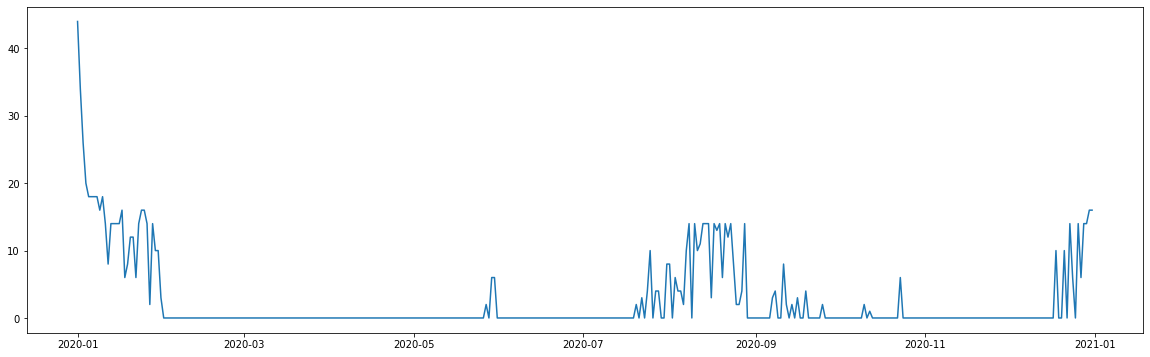

In [38]:
daily['inflow_outflow_difference'] = daily['All Inflow AB'] - daily['All Outflow BA']
plt.figure(figsize=(20,6))
plt.plot(daily.reset_index().groupby('Dia').agg({'inflow_outflow_difference': 'median'}) )
plt.show()

### Covid impact

As we all remember, 2020 was the year of covid, this is a huge outlier when we think about the flow of people between places as during the first lockdown only essential people were allowed to circulate.

We will now plot the flow of people before and after the first lockdown, to measure it's impact

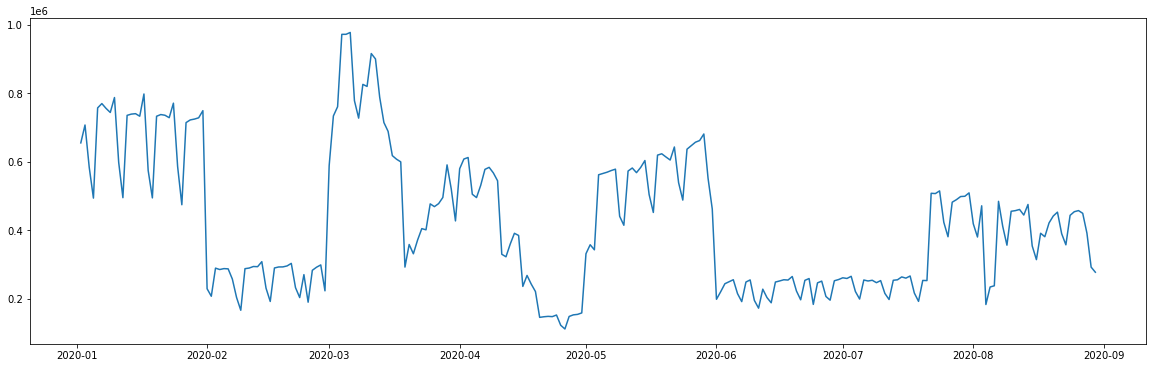

In [39]:
plt.figure(figsize=(20,6))
plt.plot(daily.loc[(daily['Nome Concelho A']!= 'PORTO') & (daily['Segmento'] == 'Nacionais') & (daily.index > '2020-01-01') & (daily.index < first_lockdown_end + timedelta(days=120))].reset_index().groupby(
    ['Dia']).agg({'Nacionais AB': 'sum'}))
plt.show()

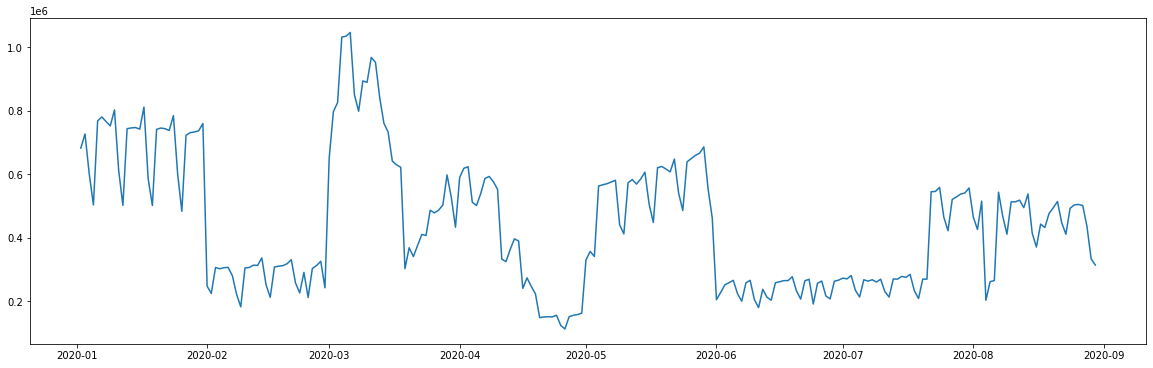

In [40]:
plt.figure(figsize=(20,6))
plt.plot(daily.loc[(daily['Nome Concelho B']!= 'PORTO')  & (daily.index > '2020-01-01') & (daily.index < first_lockdown_end + timedelta(days=120))].reset_index().groupby(
    ['Dia']).agg({'All Outflow BA': 'sum'}))
plt.show()

Interestingly, in both cases we can see the same pattern, a peak around the beginning of march, when covid was already on the news and there were talks of lockdowns, presumably this is due to the fact that with lockdown people wanted to return to their home town, thus the big influx and outflux.

Given that this was such a big outlier when we train our model we will be removing them.

## Daily Models

### Individual concelho analysis

We will now do the trend/stationarity analysis just for one concelho. Given that we have 17 concelhos, it would be impratical to print all of them here

In [41]:
concelho_to_analyse = 'CC1318'

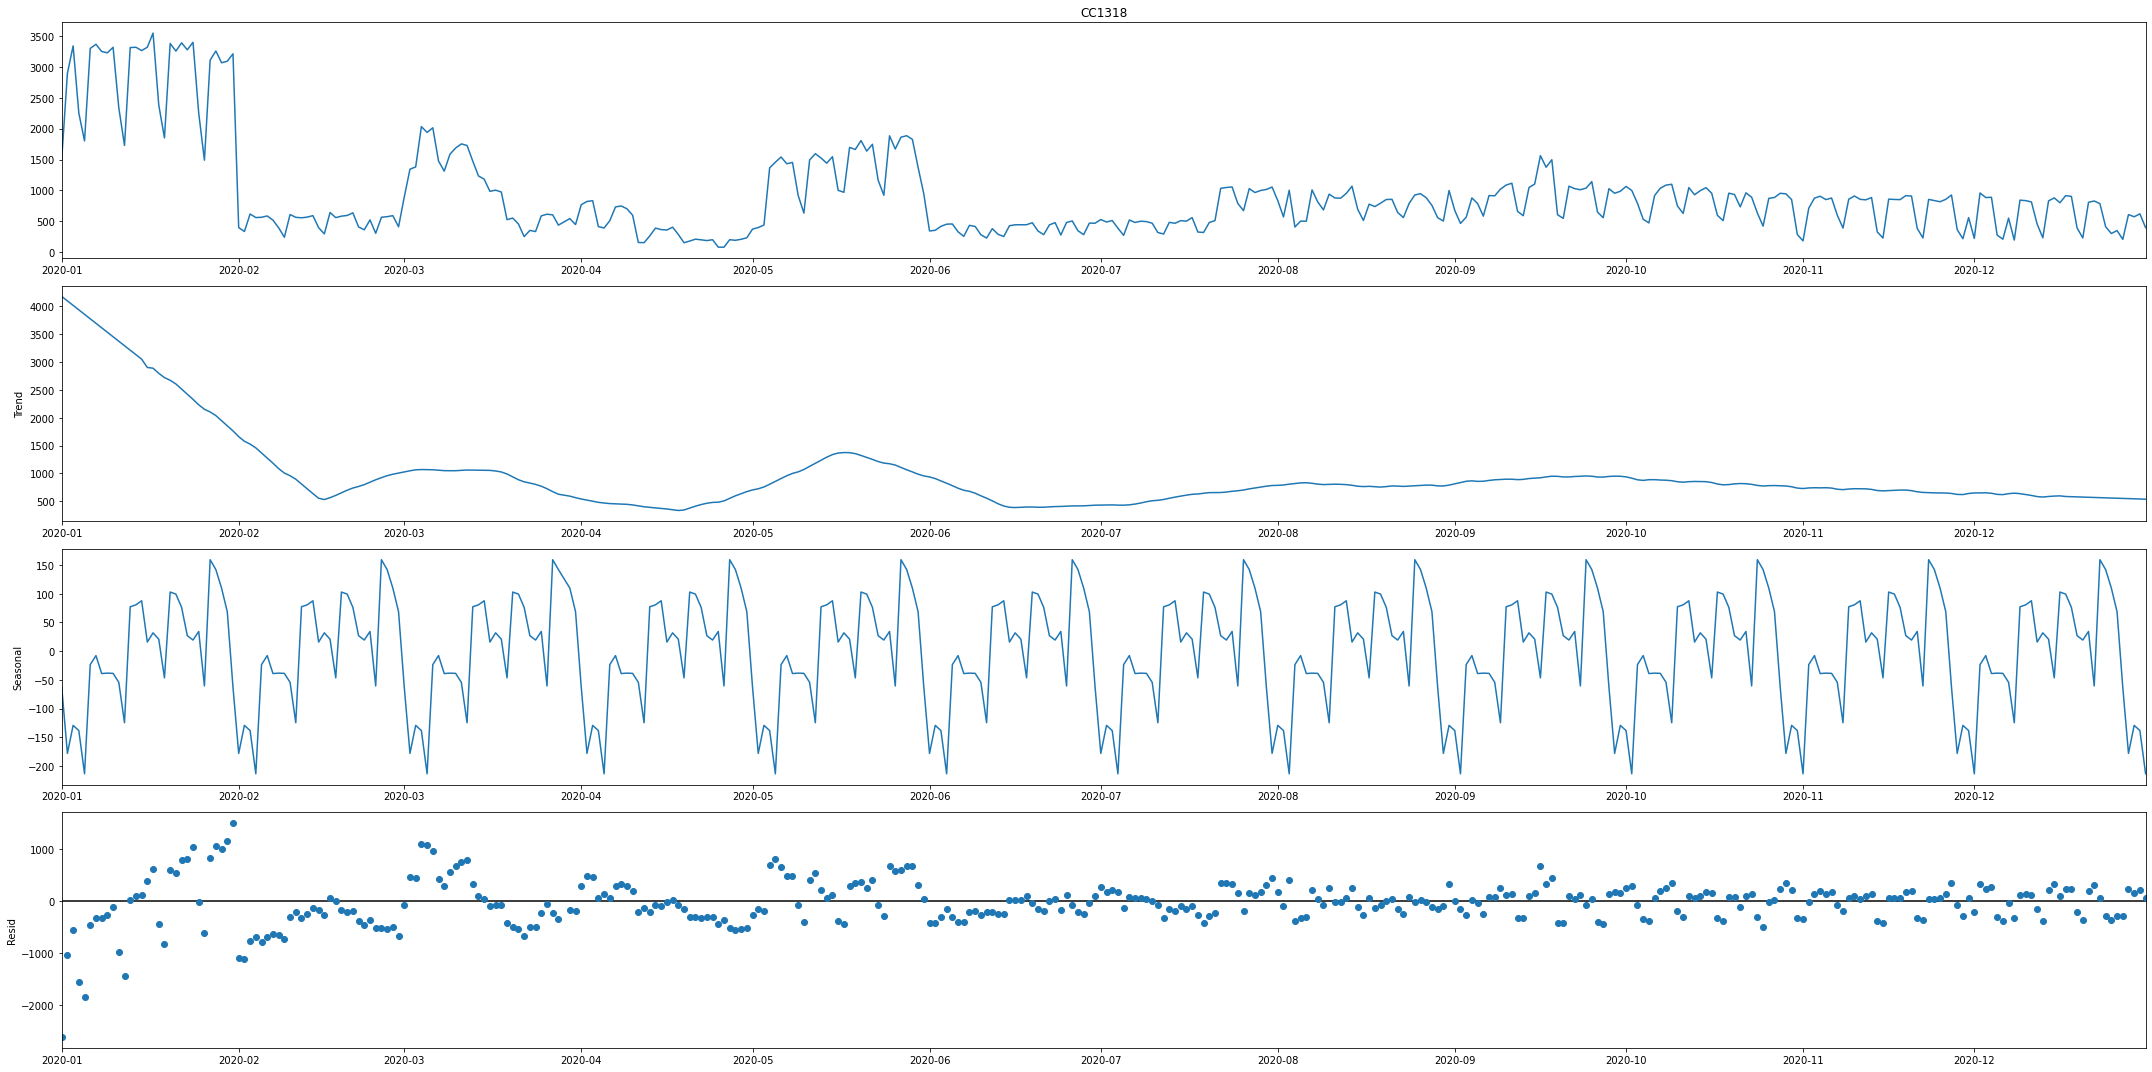

In [42]:
plot_seasonal_decompose(daily_inflow_nationals, concelho_to_analyse, (30, 15)).plot().show()

In [43]:
check_stationarity(daily_inflow_nationals, concelho_to_analyse)

'Data is stationary'

### Feature creation and correlation analysis

In this section we will create some new variables and analyse their correlation with the variable we are trying to predict.

Since we won't be using the traditional ARIMA model we need to give some context to our algorithm.

For this we will create the following new variables:
- Weather variables - to check if the weather influences the inflow or outflow of nationals. Since the nature of most of this inflow/outflow is probably commuters we believe these variables won't have much impact but we will check them anyway.
- Date variables - to check if the date or anything abstracted from that has any impact on the inflow/outflow of nationals.
- Moving averages - we will average the previous x days from the day we are using, this can help the model understand the trend of the variable.
- Lag variables - these input variables are generated from the mesurements from the previous days. Like the moving averages, these variables are used to give context to our model.

To check the impact of all of the variables on what we want to predict we will be using a correlation matrix.


#### Date and weather variables

In [44]:
daily_no_march = pd.concat([daily_inflow_nationals['2020-01-01': '2020-03-01'], daily_inflow_nationals['2020-05-01': '2020-12-31']])

In [45]:
columns_to_correlate = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir',
       'wspd', 'wpgt', 'pres',
       'date_of_measurement', 'time_of_measurement', 'day', 'month', 'month_year', 'weekday_number',
       'is_weekend', 'weekday_written', 'week_of_year', 'day_of_year',
       'is_holiday', 'season', 'is_winter', 'is_spring', 'is_summer',
       'is_autumn', 'quarter']

<module 'matplotlib.pyplot' from '/Users/newjoiner/opt/anaconda3/envs/wdl/lib/python3.8/site-packages/matplotlib/pyplot.py'>

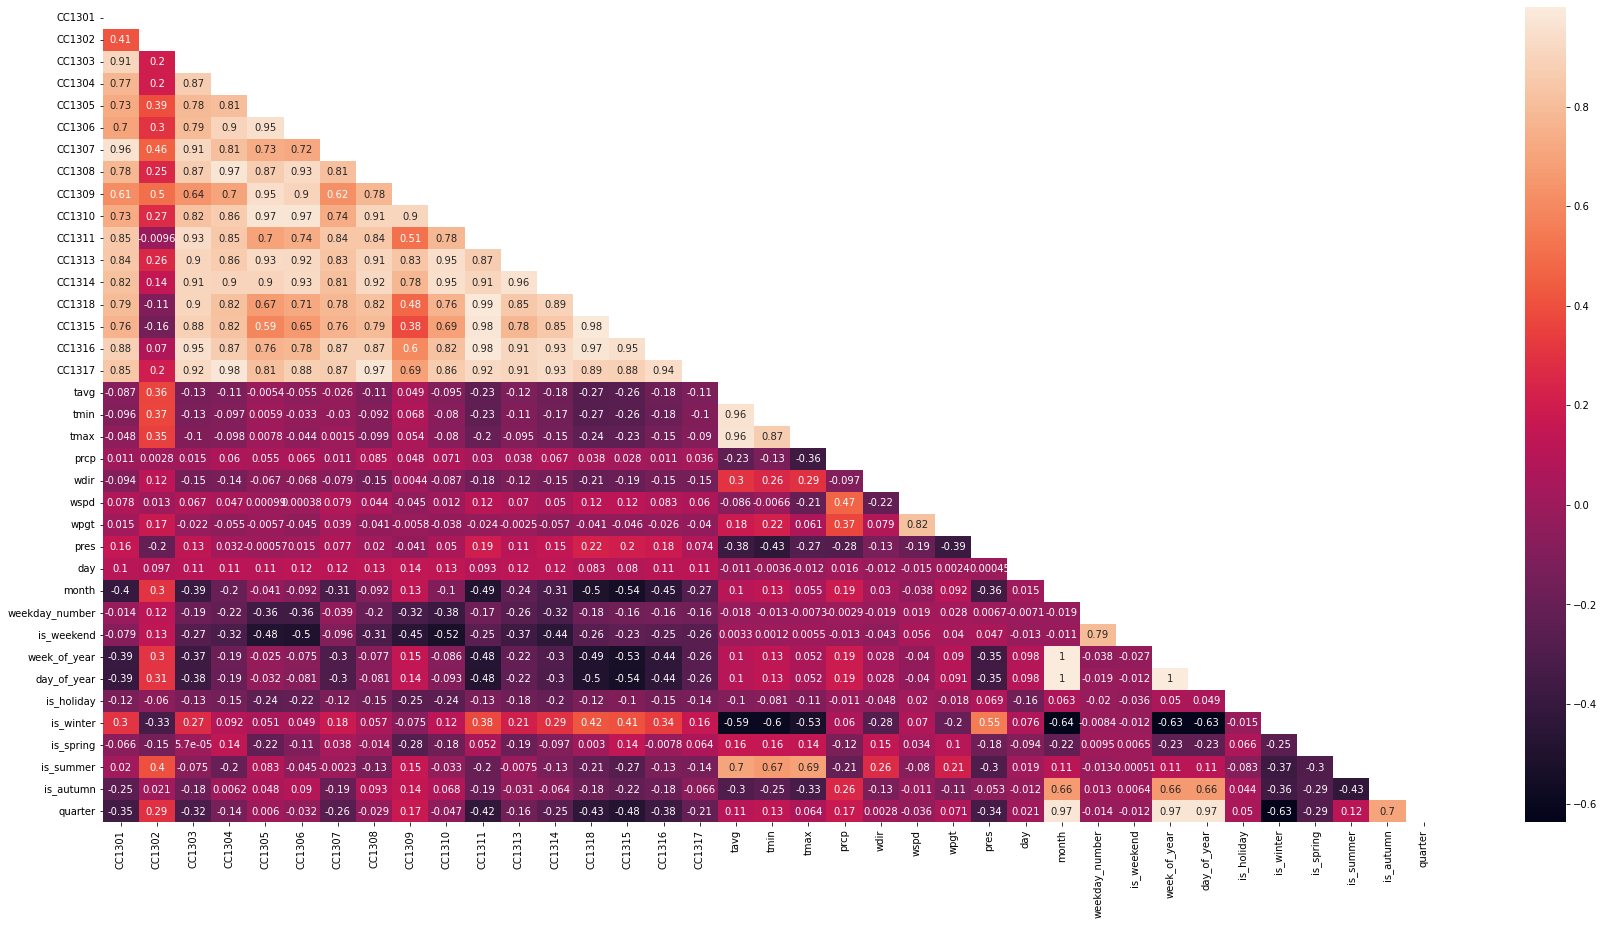

In [46]:
generate_correlation(columns=concelhos_to_use + columns_to_correlate, dataframe=daily_no_march, figure_size=(30, 15))

#### Rolling averages

We will now create rolling averages. 

We use it as a way of smoothing, to remove any noise in the dataset. In order to choose the window we want to use, we will generate 2, 3, 5 and 7 days moving averages and then use the graph to choose which one we want to use.

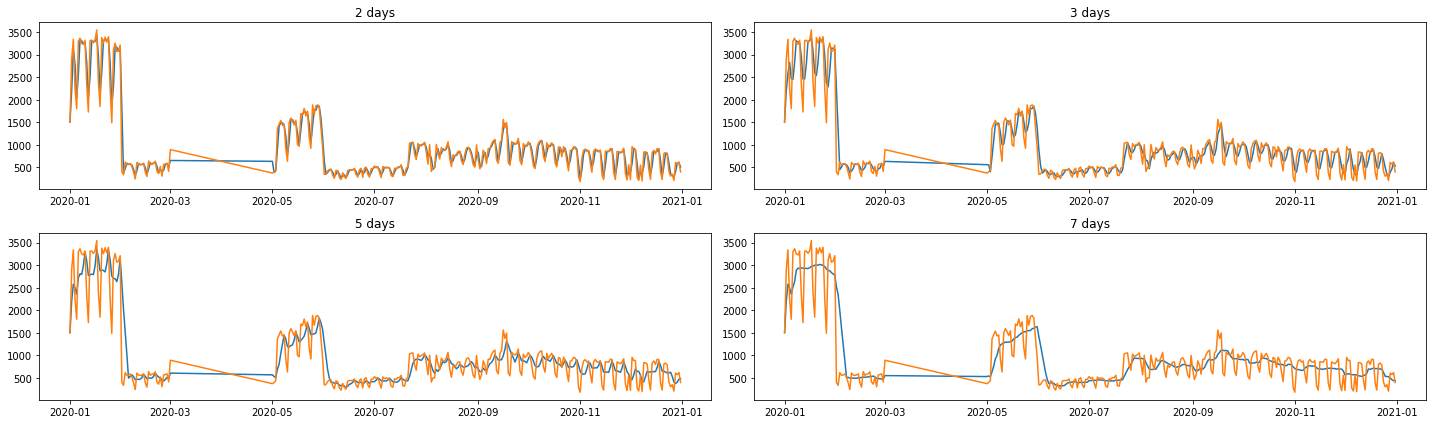

In [47]:
moving_7, moving_5, moving_3, moving_2, plot = generate_moving_averages(daily_no_march, concelhos_to_use=concelhos_to_use, concelho_to_analyse=concelho_to_analyse, period='days')
plot

Looks like our best option is to use the moving average of 2 days, we will merge it with our original dataframe and check their correlation

In [48]:
with_rolling = daily_no_march.merge(moving_2, left_index=True, right_index=True, suffixes=('', '_moving_2_days'))

<module 'matplotlib.pyplot' from '/Users/newjoiner/opt/anaconda3/envs/wdl/lib/python3.8/site-packages/matplotlib/pyplot.py'>

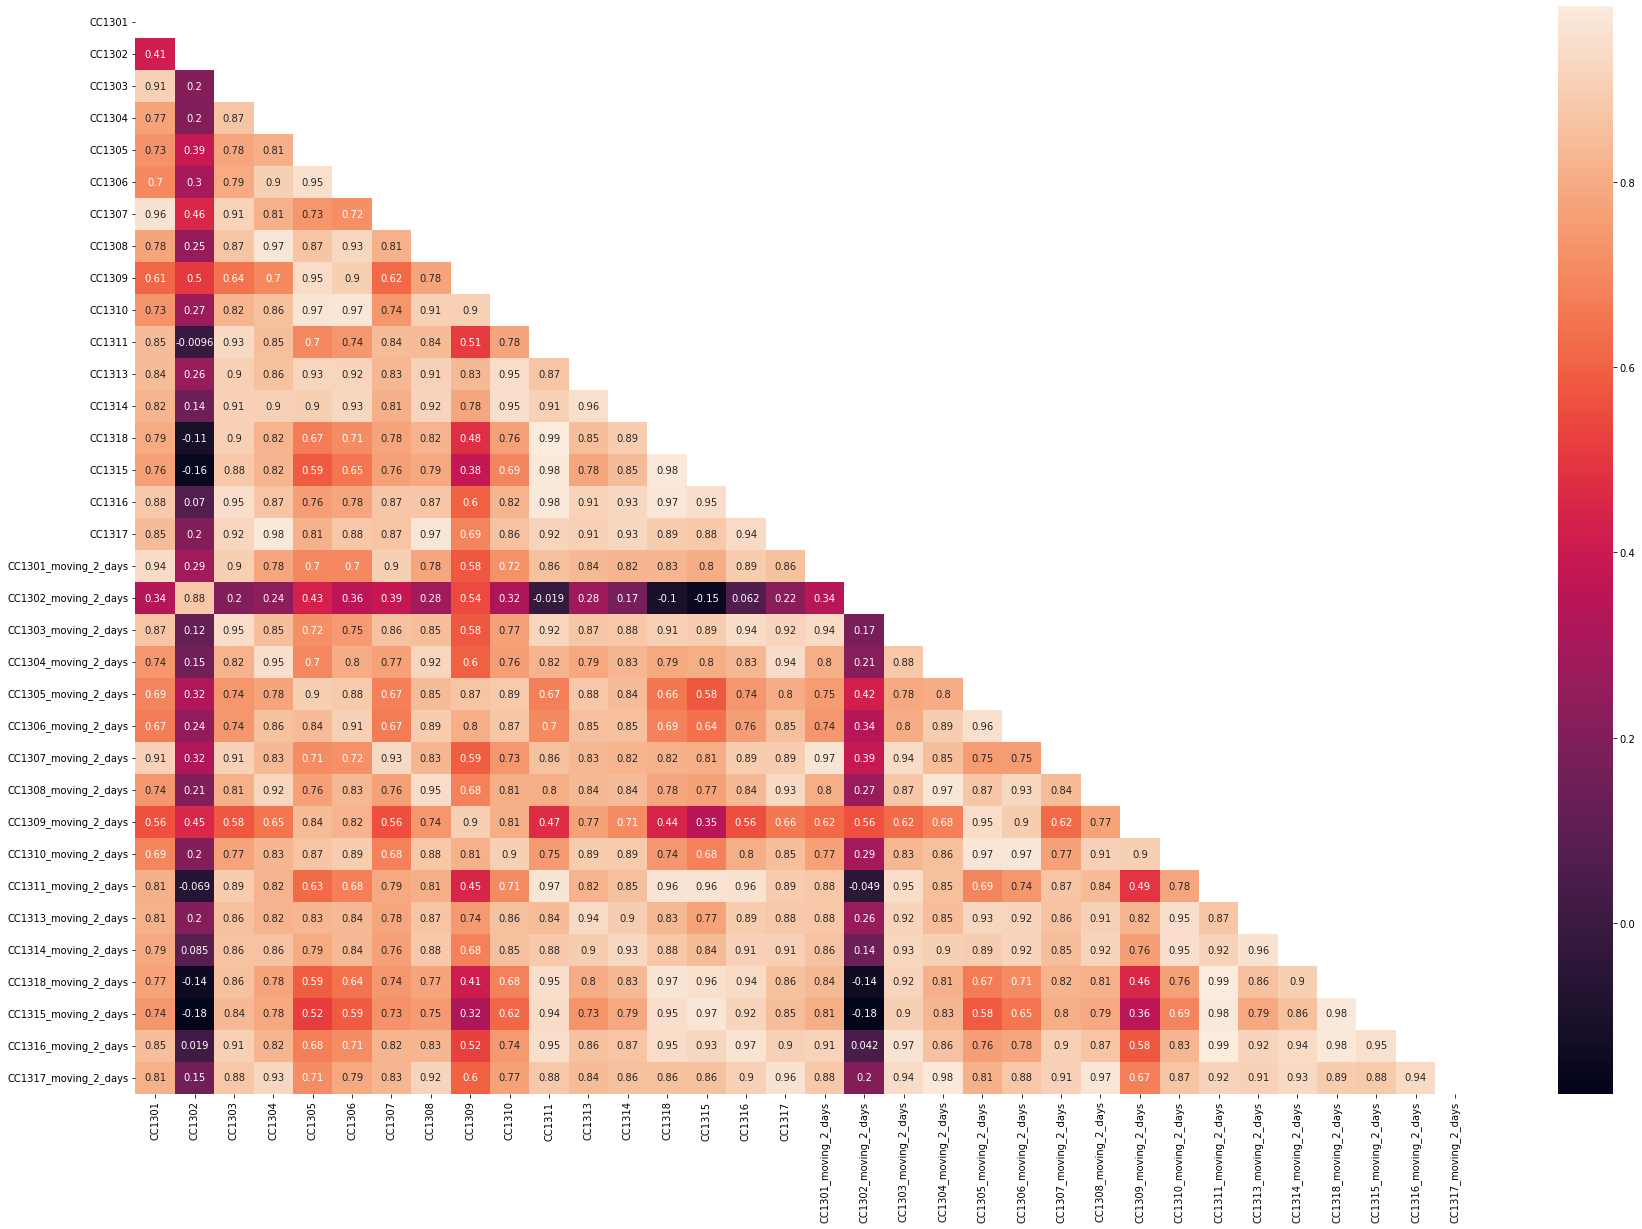

In [49]:
moving_average_columns = [f'{concelho}_moving_2_days' for concelho in concelhos_to_use]
generate_correlation(columns=concelhos_to_use + moving_average_columns, dataframe=with_rolling, figure_size=(30, 20))

#### Lagged variables

Checking columns to lag

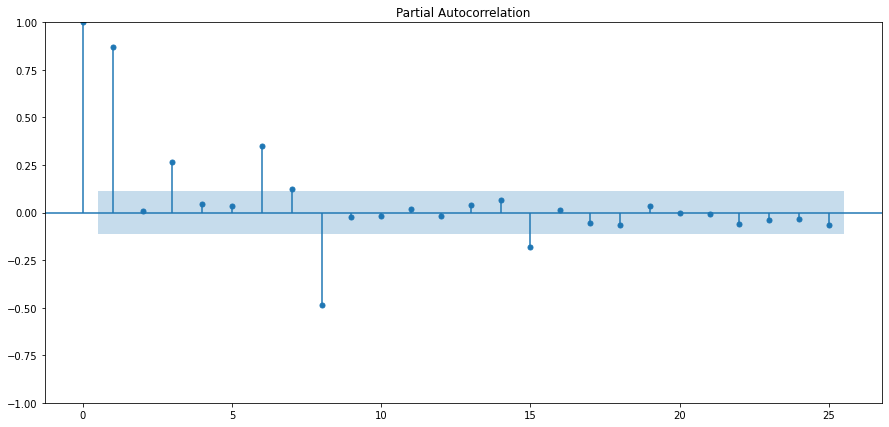

In [50]:
fig, ax = plt.subplots(figsize=(15,7))
plot_pacf(daily_no_march[concelho_to_analyse], ax=ax, method='ywm')
plt.show()

In [51]:
columns_to_lag = [f'{concelho}_lagged' for concelho in concelhos_to_use]

pivot_copy = daily_no_march[concelhos_to_use].copy(deep=True)
pivot_copy.columns = columns_to_lag
pivot_lagged = pd.concat([daily_inflow_nationals, pivot_copy.shift(1)], axis=1)

<module 'matplotlib.pyplot' from '/Users/newjoiner/opt/anaconda3/envs/wdl/lib/python3.8/site-packages/matplotlib/pyplot.py'>

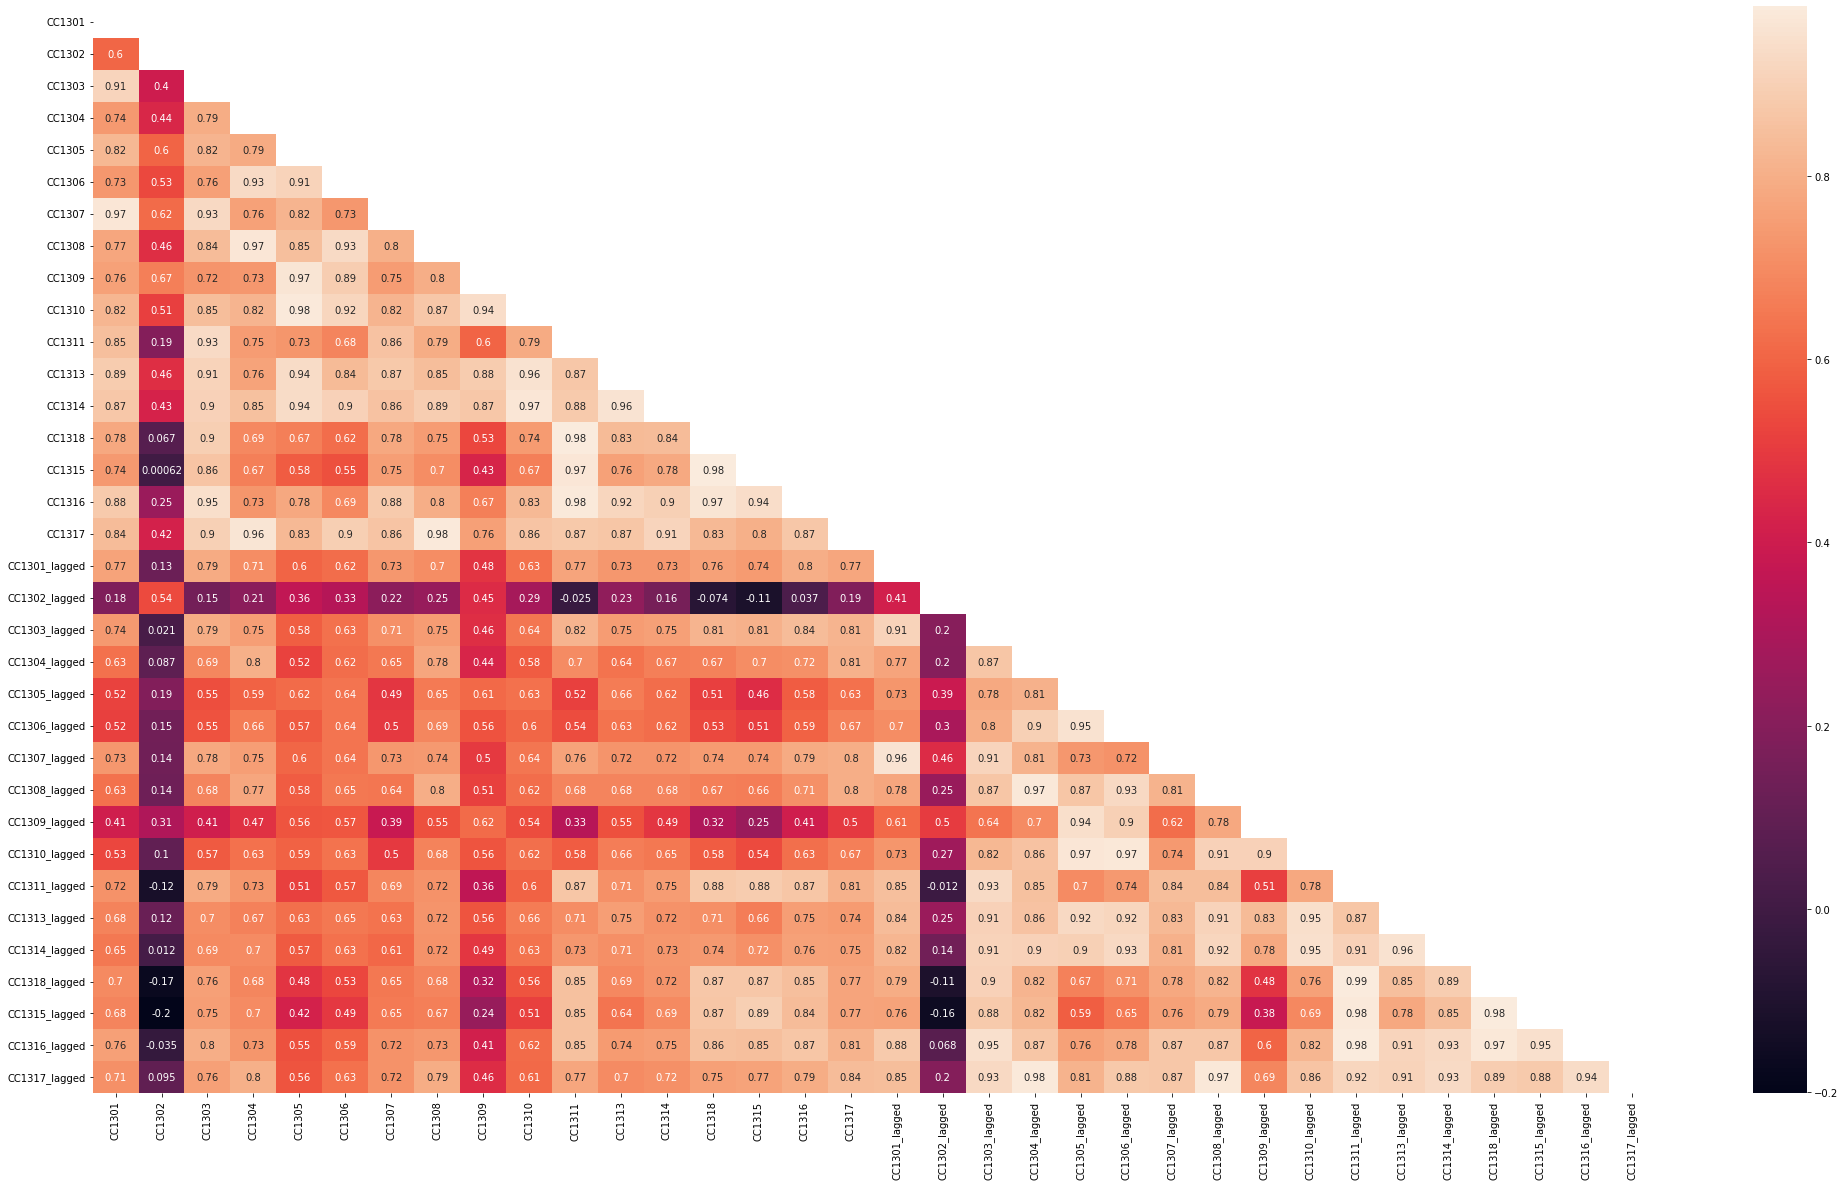

In [52]:
generate_correlation(columns=concelhos_to_use + columns_to_lag, dataframe=pivot_lagged, figure_size=(35, 20))

Let's summarise before adding the new columns to the training dataset.

| Concelho Name      | Concelho Code | Date variables | Weather variables | Moving averages | Lagged variables | 
|:------------------:|:-------------:|:--------------:|:-----------------:|:---------------:|:----------------:|
| Amarante           | CC1301        |                |                   | CC1301          | CC1301           |
| Baião              | CC1302        |                |                   | CC1302          | CC1302           |
| Felgueiras         | CC1303        |                |                   | CC1303          | CC1303           |
| Gondomar           | CC1304        |                |                   | CC1304          | CC1303, CC1304   |
| Lousada            | CC1305        |                |                   | CC1305          | CC1302           |
| Maia               | CC1306        | is_weekend     |                   | CC1306          | CC1315           |
| Marco de Canaveses | CC1307        |                |                   | CC1307          | CC1307           |
| Matosinhos         | CC1308        |                |                   | CC1308          | CC1308           |
| Paços de Ferreira  | CC1309        |                |                   | CC1309          | CC1309           |
| Paredes            | CC1310        | is_weekend     |                   | CC1310          | CC1310           |
| Penafiel           | CC1311        |                |                   | CC1311          | CC1311           |
| Póvoa de Varzim    | CC1313        |                |                   | CC1313          | CC1313           |
| Santo Tirso        | CC1314        |                |                   | CC1314          | CC1314           |
| Trofa              | CC1318        |                |                   | CC1318          | CC1318           |
| Valongo            | CC1315        |                |                   | CC1315          | CC1315           |
| Vila do Conde      | CC1316        |                |                   | CC1316          | CC1316           |
| Vila Nova de Gaia  | CC1317        |                |                   | CC1317          | CC1317           |


*Note*: rows left blank indicate there is no variable with correlation high enough


In [53]:
training_dataframe = pivot_lagged[columns_to_lag].merge(
    daily_no_march, right_index=True, left_index=True
).merge(
    with_rolling[moving_average_columns], right_index=True, left_index=True
)
training_dataframe = training_dataframe.fillna(value=0)

### Training

We will now train our model. Because we have so many municiaplities (17) to train on we will only run this for one municipality, but in production we would need to train all of them.

We won't do that here because it would be a lot of information for the reader.

We will split the training and testing dataset by months, to train we will use the first 10 months of the year and we wil test it on the last 2 months.

In [54]:
training_start = '2020-01-01'
training_end = '2020-10-31'
test_start = '2020-11-01'
test_end = '2020-12-31'

Here we will only be using the CC1317 lagged and moving averages because even these variables are highly correlated to any other we might add (for example CC1317 moving average is highly correlated (0.94) to another variable CC1316 moving average)

In [55]:
columns_to_use = ['CC1318_moving_2_days','CC1318_lagged']

In [56]:
model = LinearRegression()
model.fit(training_dataframe[training_start:training_end][columns_to_use], training_dataframe[training_start:training_end]['CC1318'])

LinearRegression()

In [57]:
predictions = model.predict(training_dataframe[test_start:test_end][columns_to_use])

Text(0.5, 1.0, 'CC1318')

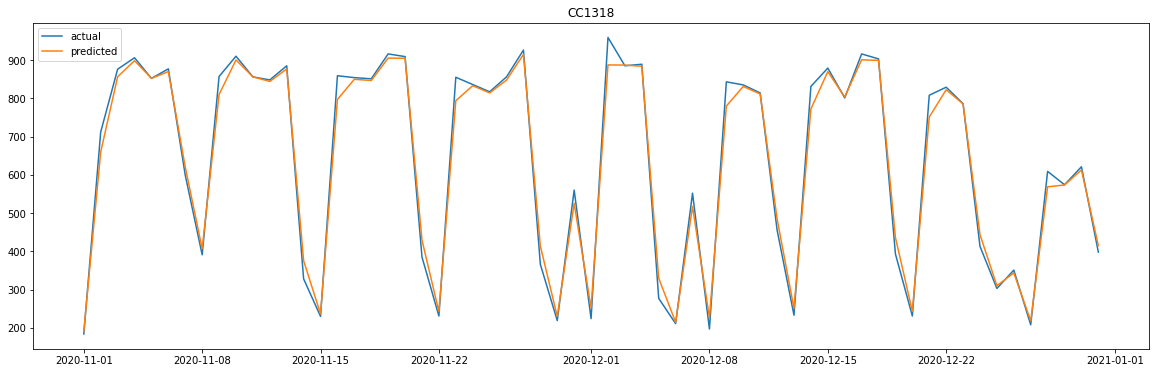

In [58]:
plt.figure(figsize=(20,6))
results = daily_inflow_nationals[test_start:test_end].copy(deep=True)
results['preds'] = predictions
plt.plot(results.index, results[concelho_to_analyse], label='actual')
plt.plot(results.index, results['preds'], label='predicted')
plt.legend(loc='upper left')
plt.title(concelho_to_analyse)

In [59]:
mean_absolute_error(results[concelho_to_analyse], predictions)

20.49841785199877

As we can see our model works fairly well most of the time, only really faltering when reaching peaks.

## Monthly models

In this section the analysis will be very similar to the section above, with the distinction that the period will be monthly instead of daily.

### Individual concelho analysis

In [60]:
concelho_to_analyse = 'CC1318'

Removing covid

In [61]:
monthly_inflow_nationals = pd.concat([monthly_inflow_nationals['2020-01-01': '2020-02-29'], monthly_inflow_nationals['2020-05-01': '2020-12-31']])

Analysing Stationarity

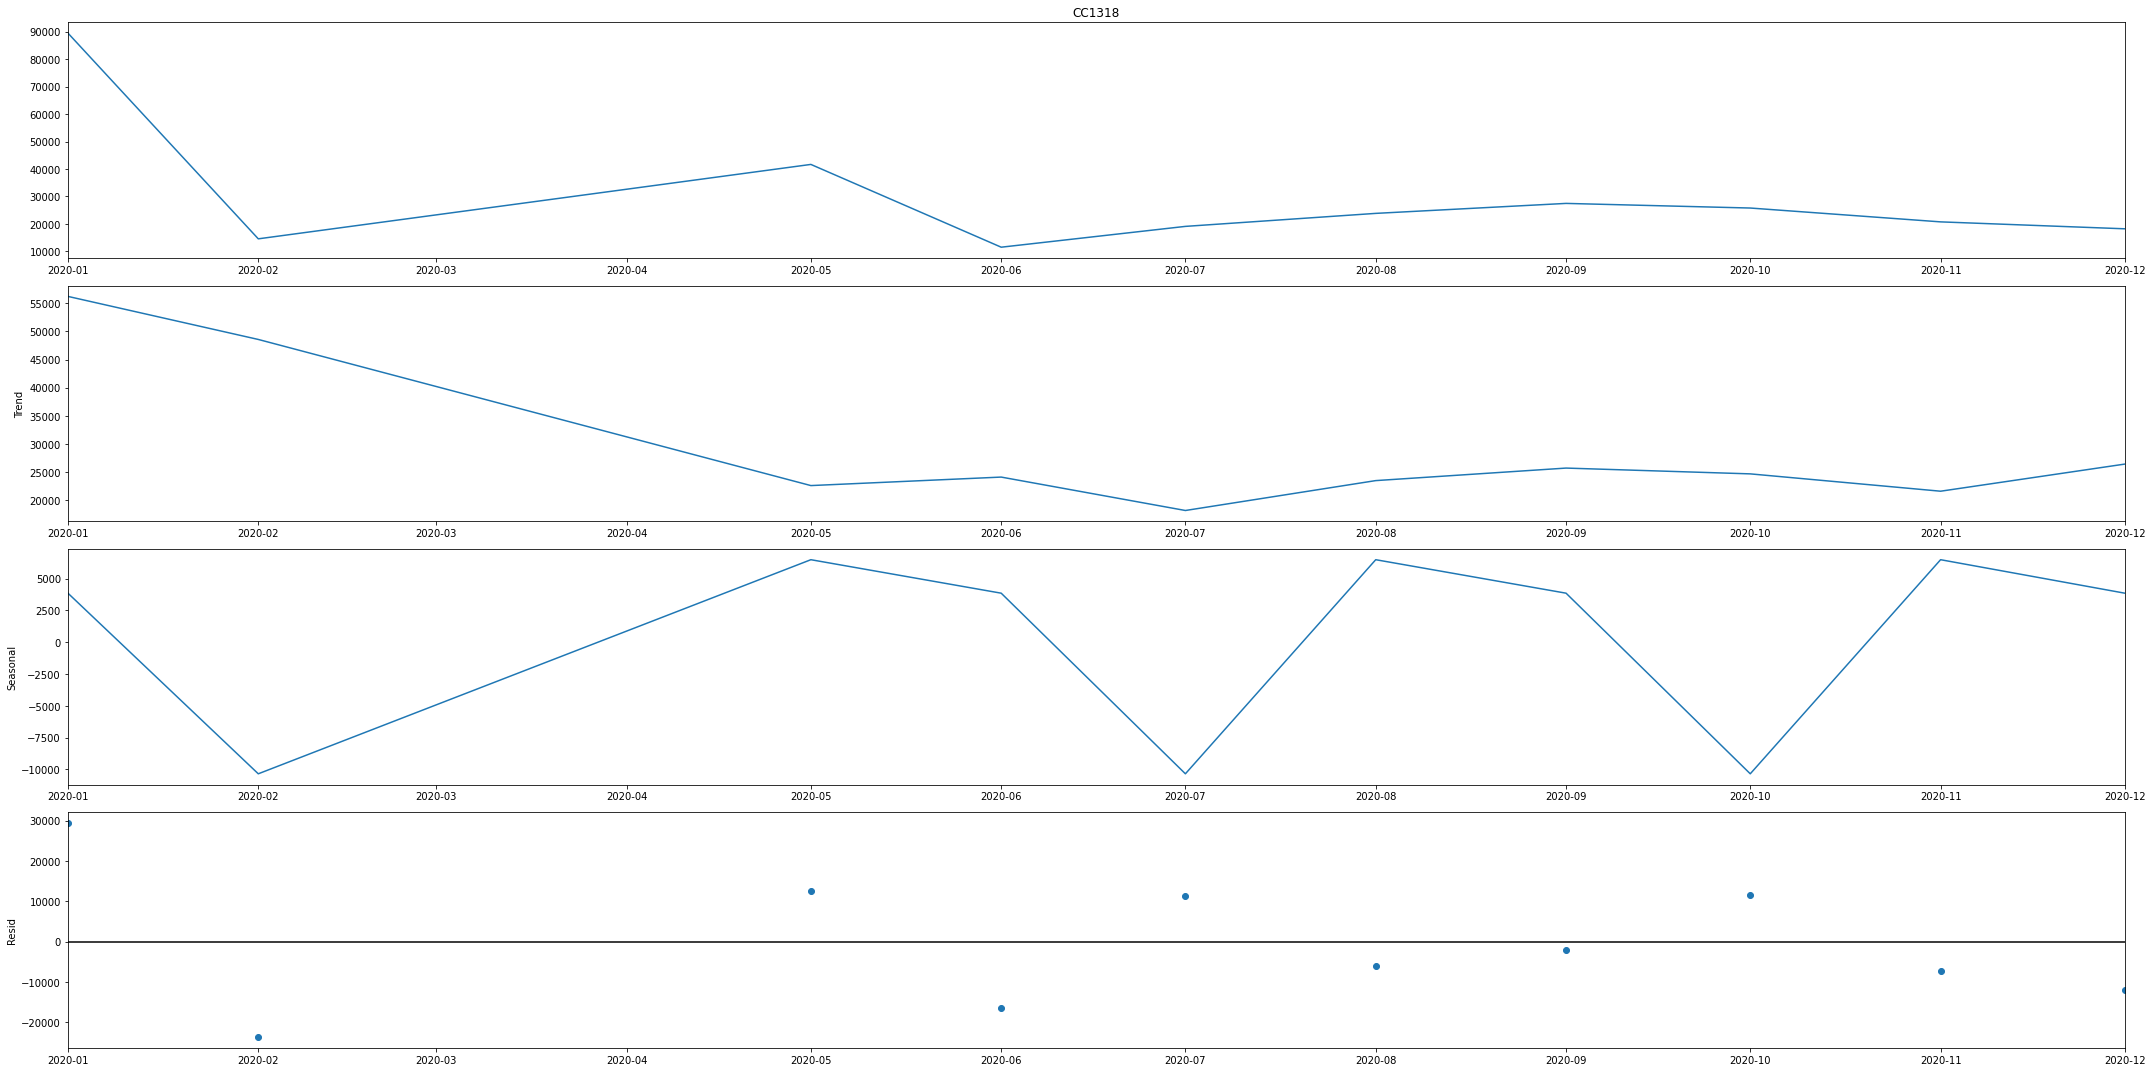

In [62]:
plt.rcParams['figure.figsize'] = (30, 15)
result = seasonal_decompose(monthly_inflow_nationals[concelho_to_analyse].dropna(), extrapolate_trend='freq', period=3) 
result.plot()
plt.show()

In [63]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(monthly_inflow_nationals[concelho_to_analyse].dropna())
if pval < 0.05:
    print('Data is stationary')
else:
    print('Data is not stationary')

Data is stationary


### Feature creation and correlation analysis

#### Date and weather variables

In [64]:
columns_to_correlate = ['tavg', 'tmin', 'tmax', 'prcp',
       'wspd', 'pres',
       'date_of_measurement', 'time_of_measurement', 'month', 'month_year', 
       'season', 'is_winter', 'is_spring', 'is_summer',
       'is_autumn', 'quarter']

<module 'matplotlib.pyplot' from '/Users/newjoiner/opt/anaconda3/envs/wdl/lib/python3.8/site-packages/matplotlib/pyplot.py'>

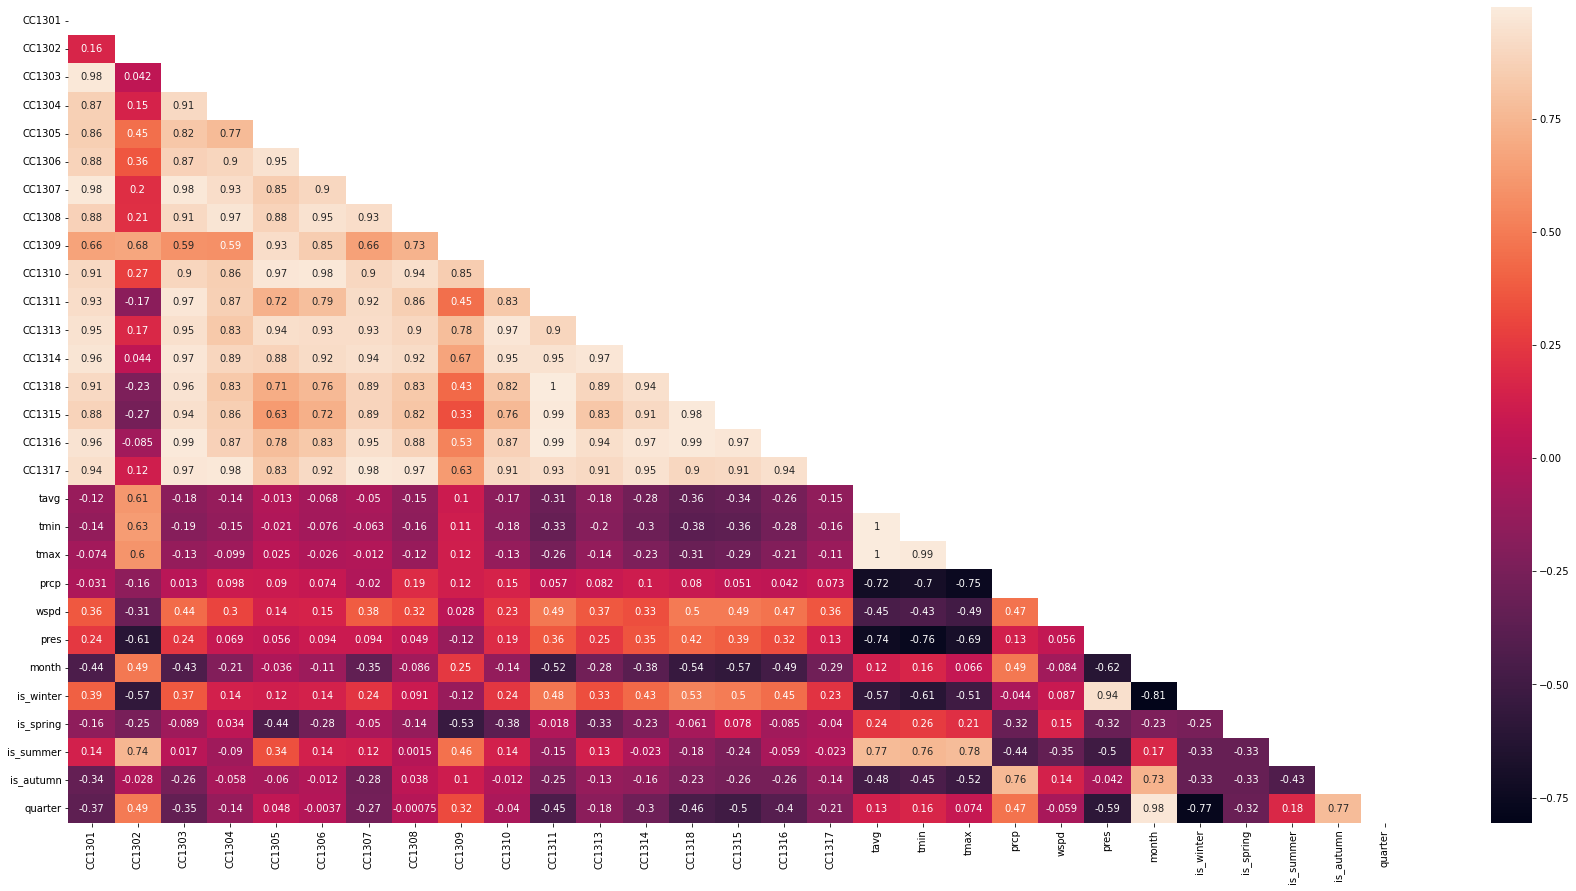

In [65]:
generate_correlation(columns=concelhos_to_use + columns_to_correlate, dataframe=monthly_inflow_nationals, figure_size=(30, 15))

#### Rolling averages

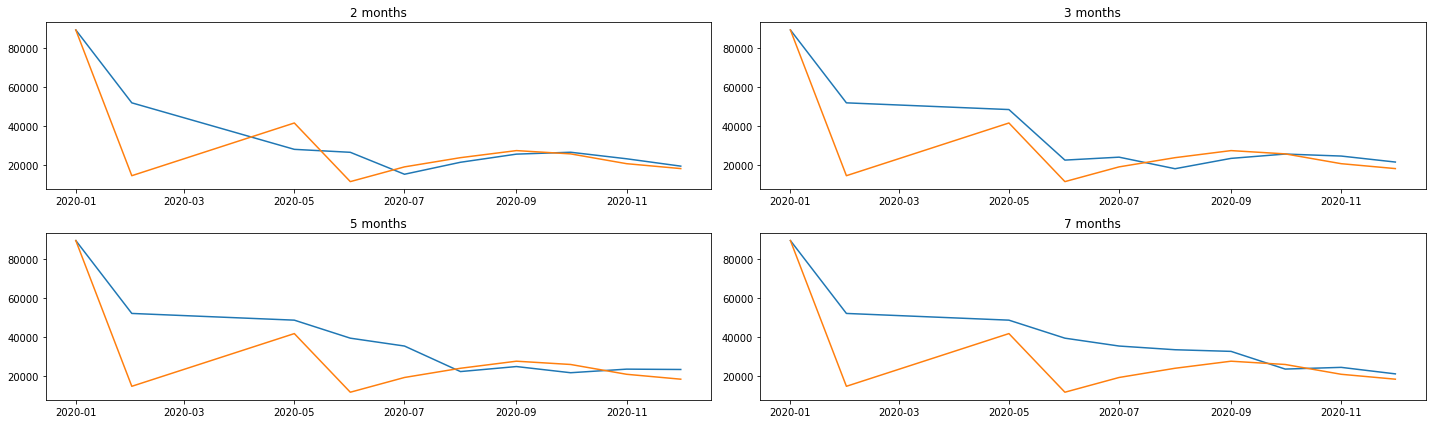

In [66]:
moving_7, moving_5, moving_3, moving_2, plot = generate_moving_averages(monthly_inflow_nationals, concelhos_to_use=concelhos_to_use, concelho_to_analyse=concelho_to_analyse, period='months')
plot

On the first few months it looks like the average doesn't really work, this is probably due to the fact that those were the lockdown months, which then ruin our moving average.

In [67]:
with_rolling = monthly_inflow_nationals.merge(moving_2, left_index=True, right_index=True, suffixes=('', '_moving_2_months'))

<module 'matplotlib.pyplot' from '/Users/newjoiner/opt/anaconda3/envs/wdl/lib/python3.8/site-packages/matplotlib/pyplot.py'>

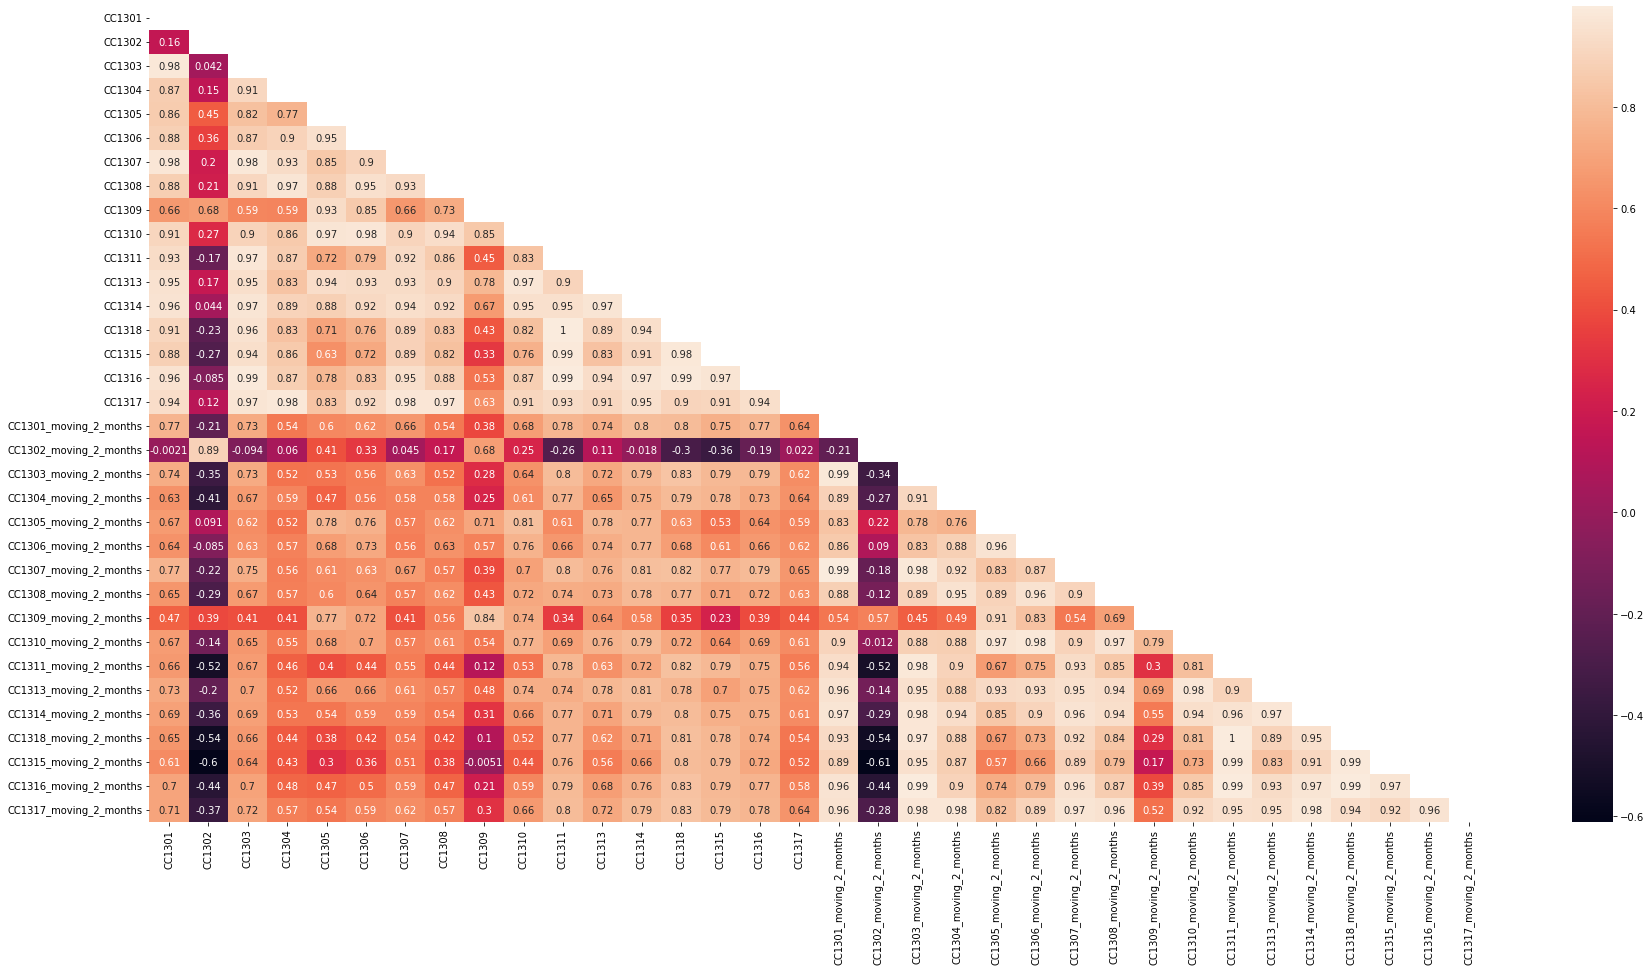

In [68]:
moving_average_columns = [f'{concelho}_moving_2_months' for concelho in concelhos_to_use]
generate_correlation(columns=concelhos_to_use + moving_average_columns, dataframe=with_rolling, figure_size=(30, 15))

#### Lagged variables

We will now check if it is useful for us to lag any column

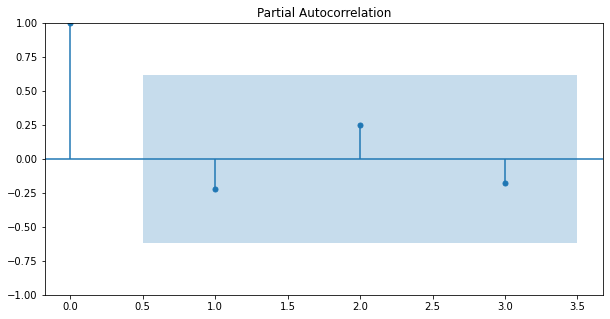

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(monthly_inflow_nationals[concelho_to_analyse], ax=ax, lags = 3)
plt.show()

In [70]:
columns_to_lag = [f'{concelho}_lagged' for concelho in concelhos_to_use]

pivot_copy = monthly_inflow_nationals[concelhos_to_use].copy(deep=True)
pivot_copy.columns = columns_to_lag
pivot_lagged = pd.concat([monthly_inflow_nationals, pivot_copy.shift(1)], axis=1)

<module 'matplotlib.pyplot' from '/Users/newjoiner/opt/anaconda3/envs/wdl/lib/python3.8/site-packages/matplotlib/pyplot.py'>

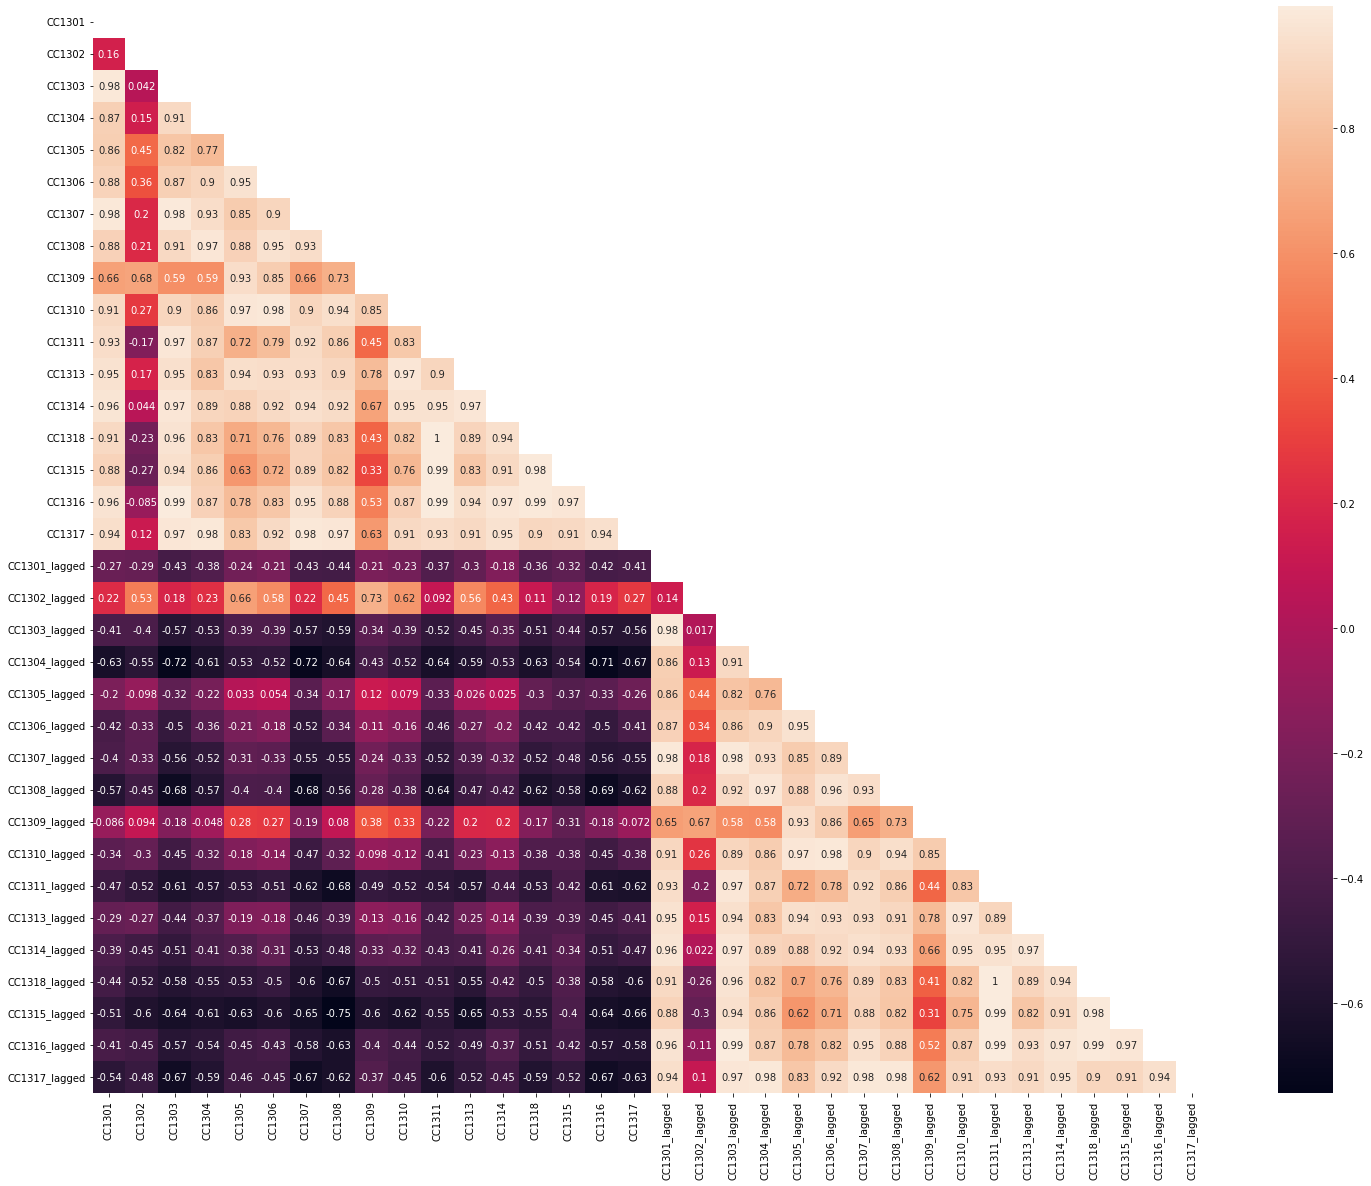

In [71]:
generate_correlation(columns=concelhos_to_use + columns_to_lag, dataframe=pivot_lagged, figure_size=(25, 20))

Let's summarise before adding the new columns to the training dataset.

| Concelho Name      | Concelho Code | Date variables | Weather variables | Moving averages | Lagged variables | 
|:------------------:|:-------------:|:--------------:|:-----------------:|:---------------:|:----------------:|
| Amarante           | CC1301        |                |                   | CC1301          | CC1304           |
| Baião              | CC1302        | is_summer      | tmin, pres        | CC1302          | CC1302           |
| Felgueiras         | CC1303        |                |                   | CC1303          | CC1304           |
| Gondomar           | CC1304        |                |                   | CC1304          | CC1304           |
| Lousada            | CC1305        |                |                   | CC1305          | CC1302           |
| Maia               | CC1306        |                |                   | CC1306          | CC1315           |
| Marco de Canaveses | CC1307        |                |                   | CC1307          | CC1304           |
| Matosinhos         | CC1308        |                |                   | CC1308          | CC1315           |
| Paços de Ferreira  | CC1309        |                |                   | CC1309          | CC1302           |
| Paredes            | CC1310        |                |                   | CC1310          | CC1315, CC1302   |
| Penafiel           | CC1311        | month          |                   | CC1311          | CC1304           |
| Póvoa de Varzim    | CC1313        |                |                   | CC1313          | CC1315           |
| Santo Tirso        | CC1314        |                |                   | CC1314          | CC1304           |
| Trofa              | CC1318        | month          | wspd              | CC1318          | CC1308           |
| Valongo            | CC1315        | month          |                   | CC1315          |                  |
| Vila do Conde      | CC1316        |                |                   | CC1316          | CC1304           |
| Vila Nova de Gaia  | CC1317        |                |                   | CC1317          | CC1304           |


*Note*: rows left blank indicate there is no variable with correlation high enough


In [72]:
training_dataframe = pivot_lagged[columns_to_lag].merge(
    monthly_inflow_nationals, right_index=True, left_index=True
).merge(
    with_rolling[moving_average_columns], right_index=True, left_index=True
)
training_dataframe = training_dataframe.fillna(value=0)

### Training

In [73]:
concelho_to_analyse = 'CC1302'
training_start = '2020-01-01'
training_end = '2020-09-30'
test_start = '2020-10-01'
test_end = '2020-12-31'

In [74]:
columns_to_use = ['CC1302_moving_2_months','CC1302_lagged', 'is_summer', 'tmin', 'pres']

In [75]:
model = LinearRegression()
model.fit(training_dataframe[training_start:training_end][columns_to_use], training_dataframe[training_start:training_end][concelho_to_analyse])

LinearRegression()

In [76]:
predictions = model.predict(training_dataframe[test_start:test_end][columns_to_use])

Text(0.5, 1.0, 'CC1302')

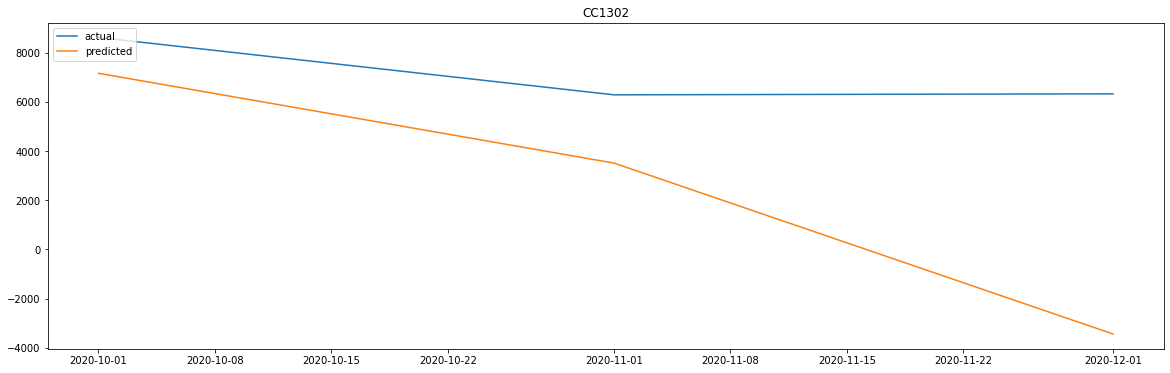

In [77]:
plt.figure(figsize=(20,6))
results = monthly_inflow_nationals[test_start:test_end].copy(deep=True)
results['preds'] = predictions
plt.plot(results.index, results[concelho_to_analyse], label='actual')
plt.plot(results.index, results['preds'], label='predicted')
plt.legend(loc='upper left')
plt.title(concelho_to_analyse)

As we can see predicting at a monthly level on the year that covid was first discovered leads to very poor results.

Another reason for these results is the lack of training data, since we only have 1 year to work with, it's only 12 samples of which we want to keep at least 3 to test on.

Our recommendation is that this analysis/traning is done again in more 'normal' times and with more data.

# Public transportation analysis

The main cause of traffic jams is simple, there's just too many cars on the road.

The solution seems simple: just build bigger roads! 

While this solution is the most obvious it isn't the correct one. This is a well studied [phenomenon](sciencedirect.com/science/article/pii/S2226585618300542) wherein the increase of road capacity only alleviates the traffic issue in the beginning, when word gets around that the new road doesn't have congestion problems anymore, more people will decide to use it, either by changing their route by car or deciding they want to use their car instead of taking public transportations and the traffic problem will arise once again.

The real solution to traffic is a good public transportation network, which must have the following characteristics:

- high frequency - if a route is only hourly, many people will prefer the convenience of driving.
- reliability - if a service unexpectedly stops running frequently, people will prefer the reliability of the car.
- high capacity - if the service is always full to the brink, people will prefer the comfort of the car.

A great way of reducing traffic is by targetting the commuters, if the commuters feel like it is as easy or easier to go by public transportation they will.

In order to check which zones need the most help we will cross validate the information we have regarding the entries and exits and the mobility datasets.

For this analysis we will consider the surrounding zones, given to us by the [STCP](https://www.stcp.pt/fotos/conteudos/mapa_zonamento_andante_final_af_site_16077203615da72506c1c5f.pdf):
![Zones in Porto transporation](zonas.png)

We will now map the zones to the concelho code we got from the mobility dataset

In [78]:
concelho_to_zone = {
    'CC1317': 'VNG',
    'CC1304': 'GDM',
    'CC1315': 'VLG',
    'CC1308': 'MTS',
    'CC1306': 'MAI',
    'CC1316': 'VCD'
}
porto_zone = 'PRT'

## Validations vs mobility analysis

### Helper functions

In [79]:
columns = ['Codigo Concelho A', 'Codigo Concelho B', 'Nome Concelho A', 'Nome Concelho B','Nacionais AB', 'All Inflow AB', 
    'hour', 'dia', 'mes', 'ano', 'Ano', 'Mês', 'Dia', 'is_weekend', 'is_holiday', 'season', '2_hour_period', 'Validações']

def get_2_hour_period(row):
    if row['Hora'] % 2 == 1:
        return row['Hora'] + 1
    return row['Hora']

def get_validations_zone_all(dataframe_to_analyse, validation_dataframe, concelho_to_analyse, with_zone=False):
    columns_to_use = columns.copy()
    if with_zone:
        columns_to_use = columns_to_use + ['ZonaEntrada', 'Operador']
    
    return dataframe_to_analyse.loc[
    (dataframe_to_analyse['Codigo Concelho A'] == concelho_to_analyse) ].merge(
        validation_dataframe, left_on=['hour','mes', 'dia'], right_on=['2_hour_period', 'Mês', 'Dia'])[columns_to_use]

def get_flow_per_concelho_hour(dataframe, concelho, column_for_concelho, metric):
    return dataframe.loc[
        (dataframe[f'Codigo Concelho {column_for_concelho}'] == concelho) & (dataframe['Nacionais AB'] > 0) & (dataframe['is_weekend'] == 0)
        ].groupby(
            [f'Nome Concelho {column_for_concelho}', 'hour']).agg({'Nacionais AB': metric}).reset_index()

def get_validacoes_per_concelho_date(dataframe, concelho_a_start, concelho_b_start):
    return dataframe.loc[
            (dataframe['ZonaEntrada'].str.startswith(concelho_a_start)) & (dataframe['ZonaSaida'].str.startswith(concelho_b_start))
            ].groupby(['2_hour_period','Dia', 'Mês', 'Ano', 'ZonaEntrada', 'Operador']).agg({'Validações': 'sum'}).reset_index()

### Analysing concelho flows

In [80]:
concelho_to_analyse = 'CC1306'

In [81]:
c = ['Dia', 'Codigo Concelho A', 'Codigo Concelho B', 'Formato Transicao', 'Nome Concelho A', 'Nome Concelho B']
df_to_analyse = original_df.copy(deep=True)
df_to_analyse['Formato Transicao'] = pd.to_datetime(df_to_analyse['Formato Transicao'], infer_datetime_format=True, utc=True)
df_to_analyse['Dia'] = pd.to_datetime(df_to_analyse['Dia'], infer_datetime_format=True)
df_to_analyse = df_to_analyse.groupby(c).agg({'Nacionais BA': 'sum', 'Nacionais AB': 'sum', 'Estrangeiros BA': 'sum', 'Estrangeiros AB': 'sum'}).reset_index()
df_to_analyse = df_to_analyse.set_index('Dia', drop=True)
df_to_analyse = df_to_analyse.sort_index()
df_to_analyse['hour'] = df_to_analyse['Formato Transicao'].dt.hour
df_to_analyse['dia'] = df_to_analyse.index.day
df_to_analyse['mes'] = df_to_analyse.index.month
df_to_analyse['ano'] = df_to_analyse.index.year
df_to_analyse['All Inflow AB'] = df_to_analyse['Nacionais AB'] + df_to_analyse['Estrangeiros AB']
df_to_analyse['All Outflow BA'] = df_to_analyse['Nacionais BA'] + df_to_analyse['Estrangeiros BA']
df_to_analyse = pd.concat([df_to_analyse['2020-01-01': '2020-03-01'], df_to_analyse['2020-05-06': '2020-12-31']])
df_to_analyse = add_date_features(df_to_analyse)

In [82]:
maia_porto = get_flow_per_concelho_hour(dataframe=df_to_analyse, concelho=concelho_to_analyse, column_for_concelho='A', metric='median')
maia_porto.sort_values(by='Nacionais AB', ascending=False).head(3)

,Nome Concelho A,hour,Nacionais AB
4,MAIA,8,7974.0
3,MAIA,6,7940.0
6,MAIA,12,7022.0


In [83]:
porto_maia = get_flow_per_concelho_hour(dataframe=df_to_analyse, concelho=concelho_to_analyse, column_for_concelho='B', metric='median')
porto_maia.sort_values(by='Nacionais AB', ascending=False).head(3)

,Nome Concelho B,hour,Nacionais AB
8,MAIA,16,9972.0
7,MAIA,14,7452.0
9,MAIA,18,6928.0


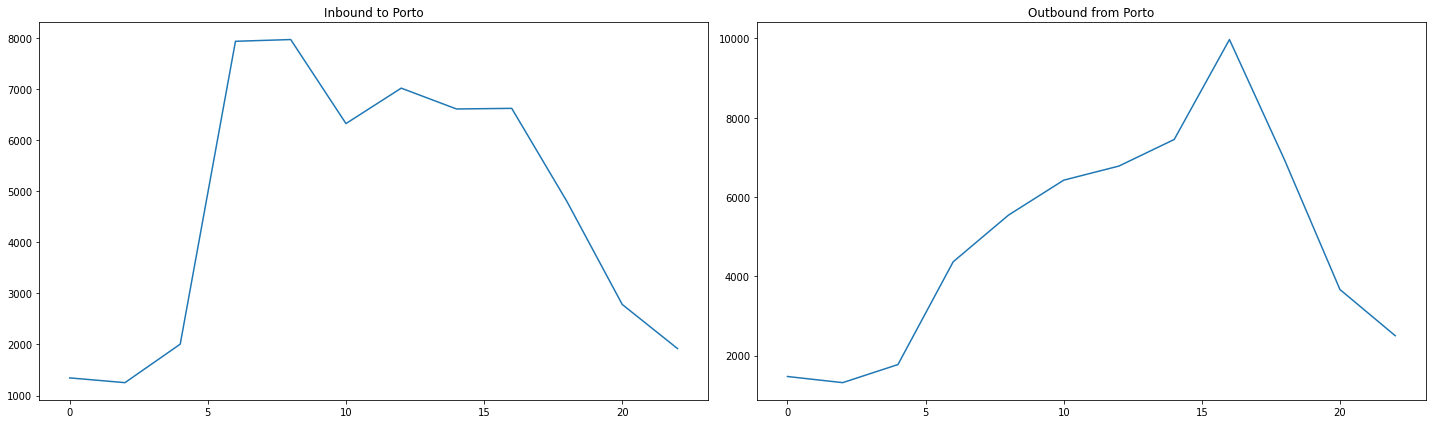

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(maia_porto['hour'], maia_porto['Nacionais AB'])
ax1.set_title('Inbound to Porto')
ax2.plot(porto_maia['hour'], porto_maia['Nacionais AB'])
ax2.set_title('Outbound from Porto')
fig.tight_layout()

We will use the MOD dataset, we chose this dataset because it has the entry and exit zone, so we can check if the final destination was the Porto city.

### Cross-checking validations

#### Helper Functions

In [85]:
def get_routes_in_zones(stop_times, starting_zone, passing_zone):
    routes_of_zone = stop_times.loc[(stop_times['zone_id'] == starting_zone) ]['route_id'].unique().tolist()
    return stop_times.loc[(stop_times['route_id'].isin(routes_of_zone)) & (stop_times['zone_id'].str.startswith(passing_zone))]['route_id'].unique().tolist()

def get_routes(dates_dict, stop_times, passing_zone, max_validations=100):
    routes_to_check = []
    for date_dict in dates_dict:
        zones_to_check = validations_flows_zone.loc[
            (validations_flows_zone['hour'] == date_dict['hour']) & 
            (validations_flows_zone['dia'] == date_dict['dia']) & 
            (validations_flows_zone['mes'] == date_dict['mes']) & 
            (validations_flows_zone['Validações'] <= max_validations)][['ZonaEntrada', 'Operador']].to_dict('records')        
        
        for zone in zones_to_check:
            if zone['Operador'] == 'Metro do Porto':
                routes_to_check = routes_to_check + get_routes_in_zones(stop_times=stop_times_metro, starting_zone=zone['ZonaEntrada'], passing_zone=passing_zone)
            if zone['Operador'] == 'STCP':
                routes_to_check = routes_to_check + get_routes_in_zones(stop_times=stop_times, starting_zone=zone['ZonaEntrada'], passing_zone=passing_zone)
    
    return list(routes_to_check)

#### Analysis

For this analysis we will:
- Import the MOD validations - to analyse the usage of each zone.
- Import the bus and metro GTFS schedules - to get where each route passes through.
- Cross check validations with the actual inflow/outflow data available
- Identify which routes had the lowest occupation to be sent for review

In [86]:
mod = pd.read_pickle('mod.pkl')
mod['date'] = mod['Ano'].astype(str) + '-' + mod['Mês'].astype(str)+ '-' + mod['Dia'].astype(str) + ' ' + mod['Hora'].astype(str) + ':00:00'
mod['date'] = pd.to_datetime(mod['date'])
mod = mod.set_index('date')
mod = mod.sort_index()
mod['2_hour_period'] = mod.apply(get_2_hour_period, axis=1)
mod['ZonaEntrada'] = mod['ZonaEntrada'].str.strip()
routes, stops, stop_times, trips, shapes = gtfs.import_gtfs("InterMunicipality/GTFS/gtfs_bus.zip")
routes_metro, _, stop_times_metro, _, _ = gtfs.import_gtfs("InterMunicipality/GTFS/gtfs_metro.zip")

Here we will get all validations for a certain concelho and merge them with the inflow/outflow data we have.

In [87]:
validations_per_date_zone = get_validacoes_per_concelho_date(mod, concelho_a_start=concelho_to_zone[concelho_to_analyse], concelho_b_start=porto_zone)
validations_per_date = validations_per_date_zone.groupby(['2_hour_period', 'Dia', 'Mês', 'Ano']).agg({'Validações': 'sum'}).reset_index()

In [88]:
validations_flows_zone = get_validations_zone_all(
    dataframe_to_analyse=df_to_analyse, 
    validation_dataframe=validations_per_date_zone, 
    concelho_to_analyse=concelho_to_analyse, 
    with_zone=True
)

In [89]:
validations_flows = get_validations_zone_all(
    dataframe_to_analyse=df_to_analyse, 
    validation_dataframe=validations_per_date, 
    concelho_to_analyse=concelho_to_analyse, 
    with_zone=False
)
validations_flows['ratio_of_used_public_transportation'] = validations_flows['Validações'] / validations_flows['All Inflow AB']
validations_flows.head(2)

,Codigo Concelho A,Codigo Concelho B,Nome Concelho A,Nome Concelho B,Nacionais AB,All Inflow AB,hour,dia,mes,ano,Ano,Mês,Dia,is_weekend,is_holiday,season,2_hour_period,Validações,ratio_of_used_public_transportation
0,CC1306,CC1312,MAIA,PORTO,4470.0,4580.0,0,1,1,2020,2020,1,1,0,True,winter,0,596,0.130131
1,CC1306,CC1312,MAIA,PORTO,2084.0,2120.0,2,1,1,2020,2020,1,1,0,True,winter,2,627,0.295755


In [90]:
validations_flows.loc[(validations_flows['hour'].isin([6, 8, 12])) & (validations_flows['is_weekend'] == 0)].groupby(['season']).agg({'ratio_of_used_public_transportation': 'median'})

,ratio_of_used_public_transportation
season,
autumn,0.401395
spring,0.397223
summer,0.431104
winter,0.538514


We can see that the usage doesn't change much across seasons, this is due to the fact that we are analysing it in a commuters standpoint, which is a year round demand.

Since our use case is for commuters, we will focus on hours 6, 8 and 10 and on weekdays that aren't holidays.

In [91]:
date_to_check = validations_flows.loc[
    (validations_flows['hour'].isin([6, 8, 12])) & (validations_flows['is_weekend'] == 0) & (~validations_flows['is_holiday'])].sort_values(
        by=['ratio_of_used_public_transportation'], ascending=True
    )
date_to_check.head(5)

,Codigo Concelho A,Codigo Concelho B,Nome Concelho A,Nome Concelho B,Nacionais AB,All Inflow AB,hour,dia,mes,ano,Ano,Mês,Dia,is_weekend,is_holiday,season,2_hour_period,Validações,ratio_of_used_public_transportation
2481,CC1306,CC1312,MAIA,PORTO,11524.0,11690.0,6,29,9,2020,2020,9,29,0,False,autumn,6,1119,0.095723
2469,CC1306,CC1312,MAIA,PORTO,11502.0,11690.0,6,28,9,2020,2020,9,28,0,False,autumn,6,1130,0.096664
2493,CC1306,CC1312,MAIA,PORTO,11212.0,11388.0,6,30,9,2020,2020,9,30,0,False,autumn,6,1199,0.105286
2133,CC1306,CC1312,MAIA,PORTO,8492.0,8760.0,6,31,8,2020,2020,8,31,0,False,summer,6,923,0.105365
975,CC1306,CC1312,MAIA,PORTO,7638.0,7750.0,6,26,5,2020,2020,5,26,0,False,spring,6,817,0.105419


We will now check the routes that start in Maia and end or pass through Porto during the hours we chose.

In [92]:
routes_to_check = get_routes(date_to_check[['hour', 'dia', 'mes']].to_dict('records'), stop_times=stop_times, passing_zone='PRT', max_validations=50)

In [93]:
unique_routes = set(routes_to_check)
route_count = {}
for route in unique_routes:
    count_route = routes_to_check.count(route)
    route_count[route] = count_route

In [94]:
dict(sorted(route_count.items(), key=lambda item: item[1], reverse=True))

{'602': 590,
 '604': 590,
 '603': 589,
 '600': 589,
 'C': 70,
 'E': 2,
 'F': 2,
 'B': 2}

From this output we can see that the routes 604, 602, 603 and 600 need to be looked at due to the fact that they constantly get less that 100 validations per working day in peak hours.

In [95]:
cutoffs = [6, 8, 12]
line_freq = gtfs.lines_freq(stop_times, trips, shapes, routes, cutoffs = cutoffs)

In [96]:
line_freq.loc[(line_freq.dir_id=='Outbound') & (line_freq['route_id'].isin(['600','602', '603', '604']))]

,route_id,route_name,dir_id,window,frequency,ntrips,max_freq,max_trips,geometry
135,603,603 Marquês - Maia,Outbound,8:00-12:00,34,7,20,3,"LINESTRING (-8.63027 41.23588, -8.63027 41.235..."
139,604,604 Hospital S.João - Aeroporto(via Crestins),Outbound,8:00-12:00,26,9,20,3,"LINESTRING (-8.67016 41.23710, -8.67016 41.237..."
134,603,603 Marquês - Maia,Outbound,6:00-8:00,24,5,20,3,"LINESTRING (-8.63027 41.23588, -8.63027 41.235..."
138,604,604 Hospital S.João - Aeroporto(via Crestins),Outbound,6:00-8:00,24,5,20,3,"LINESTRING (-8.67016 41.23710, -8.67016 41.237..."
131,602,602 Cordoaria - Aeroporto (via Padrão Moreira),Outbound,8:00-12:00,15,16,15,4,"LINESTRING (-8.67019 41.23702, -8.67019 41.237..."
130,602,602 Cordoaria - Aeroporto (via Padrão Moreira),Outbound,6:00-8:00,15,8,15,4,"LINESTRING (-8.67019 41.23702, -8.67019 41.237..."
123,600,600 Aliados - Maia(Barca),Outbound,8:00-12:00,9,25,8,7,"LINESTRING (-8.60738 41.24694, -8.60738 41.246..."
122,600,600 Aliados - Maia(Barca),Outbound,6:00-8:00,8,14,8,7,"LINESTRING (-8.60738 41.24694, -8.60738 41.246..."


In [97]:
gtfs.map_gdf(line_freq.loc[(line_freq.dir_id=='Outbound') & (line_freq['route_id'].isin(['600','602', '603', '604']))].reset_index(), variable='ntrips', tooltip_labels=['Route:'], tooltip_var=['route_name'])

As we can see by the map two of the routes have the airport as a destination. This is to be expected since we are analysing a covid year and there wasn't much air travel. 

In order to get routes more appropriate to non covid years we would need to run this analysis again for 2022.